# Projet 7 : Élaborer un modèle de scoring

**Exploration / features engineering & features selection**

## Consignes pour ce projet

**Consigne :**

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.
  
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.
- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.

# I. Importer les librairies & les données

## A. Importation des librairies

In [ ]:
import sys
sys.executable

In [1]:
# Librairies de base python 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import table
import missingno as msno
import gc
import time
from contextlib import contextmanager

# Modèle de ML
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Librairies sklearn
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

## B. Importation des données

In [2]:
# Importation des fichiers csv / création des dataframes
df_app_test = pd.read_csv('application_test.csv')
df_app_train = pd.read_csv('application_train.csv')
df_bureau = pd.read_csv('bureau.csv')
df_bureau_bal = pd.read_csv('bureau_balance.csv')
df_cc_bal = pd.read_csv('credit_card_balance.csv')
df_col_describe = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')
df_inst_paymts = pd.read_csv('installments_payments.csv')
df_poh_cash = pd.read_csv('POS_CASH_balance.csv')
df_prev_app = pd.read_csv('previous_application.csv')
df_smp_sub = pd.read_csv('sample_submission.csv')

## C. Gestion du code avec Git

### 1. Script pour mettre à jour la branche principale sans créer une nouvelle branche

Ce script copie les notebooks dans le répertoire Git, les ajoute, les committe et les pousse vers la branche principale (main).

In [ ]:
# Chemin des notebooks d'origine
source_dir = r"C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°7\DATA - NOTEBOOK"

# Chemin du répertoire Git
target_dir = r"C:\Users\justi\OC_Projet7"

# Copier les fichiers .ipynb spécifiques
notebooks_to_copy = ["Vacquerie_Justin_Notebook2_Projetn7.ipynb", "Vacquerie_Justin_Notebookn1_projet7.ipynb"]

print("Copie des fichiers .ipynb...")
for file_name in notebooks_to_copy:
    full_file_name = os.path.join(source_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, target_dir)
        print(f"{file_name} copié dans {target_dir}")

# Commandes Git
print("Exécution des commandes Git...")
git_commands = f'cd {target_dir} && git add *.ipynb && git commit -m "Mise à jour des notebooks" && git push origin main'
result = os.system(git_commands)

# Vérification du résultat des commandes Git
if result == 0:
    print("Les commandes Git se sont exécutées avec succès.")
else:
    print("Il y a eu une erreur lors de l'exécution des commandes Git.")

print("Processus terminé.")


Ce script copie les notebooks, bascule vers une nouvelle branche (nouvelle-branche), ajoute les fichiers, les committe et les pousse vers la nouvelle branche sur GitHub.

In [ ]:
# Chemin des notebooks d'origine
source_dir = r"C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°7\DATA - NOTEBOOK"

# Chemin du répertoire Git
target_dir = r"C:\Users\justi\OC_Projet7"

# Copier les fichiers .ipynb spécifiques
notebooks_to_copy = ["Vacquerie_Justin_Notebook2_Projetn7.ipynb", "Vacquerie_Justin_Notebookn1_projet7.ipynb"]

print("Copie des fichiers .ipynb...")
for file_name in notebooks_to_copy:
    full_file_name = os.path.join(source_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, target_dir)
        print(f"{file_name} copié dans {target_dir}")

# Commandes Git
branch_name = "nouvelle-branche"  # Nom de la branche sur laquelle vous travaillez
print(f"Basculer vers la branche {branch_name}...")
os.system(f'cd {target_dir} && git checkout {branch_name}')

print("Exécution des commandes Git...")
git_commands = f'cd {target_dir} && git add *.ipynb && git commit -m "Mise à jour des notebooks" && git push origin {branch_name}'
result = os.system(git_commands)

# Vérification du résultat des commandes Git
if result == 0:
    print("Les commandes Git se sont exécutées avec succès.")
else:
    print("Il y a eu une erreur lors de l'exécution des commandes Git.")

print("Processus terminé.")


# II. Approche exploratoire des données

## A. Structure des dataframes et taux de remplissage

### 1. Structures des dataframes

In [3]:
# Initialiser une liste des dataframes
liste_df = [df_app_test,
            df_app_train,
            df_bureau,
            df_bureau_bal,
            df_cc_bal,
            df_col_describe,
            df_inst_paymts,
            df_poh_cash,
            df_prev_app,
            df_smp_sub]

liste_df_names = ['df_app_test',
                  'df_app_train',
                  'df_bureau',
                  'df_bureau_bal',
                  'df_cc_bal',
                  'df_col_describe',
                  'df_inst_paymts',
                  'df_poh_cash',
                  'df_prev_app',
                  'df_smp_sub']

# Afficher la structure des dataframes avec leur nom
for df, nom_df in zip(liste_df, liste_df_names):
    print("Structure de", nom_df, ":", df.shape)

Structure de df_app_test : (48744, 121)
Structure de df_app_train : (307511, 122)
Structure de df_bureau : (1716428, 17)
Structure de df_bureau_bal : (27299925, 3)
Structure de df_cc_bal : (3840312, 23)
Structure de df_col_describe : (219, 5)
Structure de df_inst_paymts : (13605401, 8)
Structure de df_poh_cash : (10001358, 8)
Structure de df_prev_app : (1670214, 37)
Structure de df_smp_sub : (48744, 2)


### 2. Taux de remplissage des dataframes

In [4]:
# Afficher le taux de remplissage global des fichier
taux_global = sum(df.count().sum() for df in liste_df) / sum(df.shape[0] * df.shape[1] for df in liste_df) * 100
print(f"Taux de remplissage global de la database: {taux_global:.2f}%")

Taux de remplissage global de la database: 93.61%


In [5]:
# Afficher le taux de remplissage pour chaque dataframe
for df, nom_df in zip(liste_df, liste_df_names):
    taux_remplissage = df.count().sum() / (df.shape[0] * df.shape[1]) * 100
    print(f"{nom_df}: {taux_remplissage:.2f}%")

df_app_test: 76.19%
df_app_train: 75.60%
df_bureau: 86.50%
df_bureau_bal: 100.00%
df_cc_bal: 93.35%
df_col_describe: 87.85%
df_inst_paymts: 99.99%
df_poh_cash: 99.93%
df_prev_app: 82.02%
df_smp_sub: 100.00%


### 3. Synthèse

In [6]:
# Afficher les infos des colonnes des dataframes
for df in liste_df:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          f

In [7]:
# Synthèse de l'ensemble des colonnes dans un dataframe
liste_noms_df = ['df_app_test',
                  'df_app_train',
                  'df_bureau',
                  'df_bureau_bal',
                  'df_cc_bal',
                  'df_col_describe',
                  'df_inst_paymts',
                  'df_poh_cash',
                  'df_prev_app',
                  'df_smp_sub']

liste_indices = []
liste_colonnes = []
liste_types = []
liste_uniques = []
liste_taux_remplissage = []

for df, nom_df in zip(liste_df, liste_noms_df):
    for column in df.columns:
        liste_indices.append(nom_df)
        liste_colonnes.append(column)
        liste_types.append(df[column].dtype)
        liste_uniques.append(df[column].nunique())
        taux_remplissage = df[column].count() / len(df) * 100
        liste_taux_remplissage.append(f"{taux_remplissage:.2f}%")

synthese_data = pd.DataFrame({
    'Données': liste_indices,
    'Nom colonne': liste_colonnes,
    'Type': liste_types,
    'Valeurs uniques': liste_uniques,
    'Taux de remplissage': liste_taux_remplissage
})

synthese_data

Données                Nom colonne     Type  Valeurs uniques  \
0    df_app_test                 SK_ID_CURR    int64            48744   
1    df_app_test         NAME_CONTRACT_TYPE   object                2   
2    df_app_test                CODE_GENDER   object                2   
3    df_app_test               FLAG_OWN_CAR   object                2   
4    df_app_test            FLAG_OWN_REALTY   object                2   
..           ...                        ...      ...              ...   
341  df_prev_app              DAYS_LAST_DUE  float64             2873   
342  df_prev_app           DAYS_TERMINATION  float64             2830   
343  df_prev_app  NFLAG_INSURED_ON_APPROVAL  float64                2   
344   df_smp_sub                 SK_ID_CURR    int64            48744   
345   df_smp_sub                     TARGET  float64                1   

    Taux de remplissage  
0               100.00%  
1               100.00%  
2               100.00%  
3               100.00%  
4               100.00%  
..                  ...  
341              59.70%  
342              59.70%  
343              59.70%  
344             100.00%  
345             100.00%  

[346 rows x 5 columns]

In [10]:
# Filtrer les lignes où le taux de remplissage n'est pas égal à 100%
synthese_data_incomplete = synthese_data[synthese_data['Taux de remplissage'] != '100.00%']

# Afficher le DataFrame filtré
synthese_data_incomplete

Données                Nom colonne     Type  Valeurs uniques  \
8    df_app_test                AMT_ANNUITY  float64             7491   
10   df_app_test            NAME_TYPE_SUITE   object                7   
20   df_app_test                OWN_CAR_AGE  float64               52   
27   df_app_test            OCCUPATION_TYPE   object               18   
40   df_app_test               EXT_SOURCE_1  float64            27207   
..           ...                        ...      ...              ...   
339  df_prev_app             DAYS_FIRST_DUE  float64             2892   
340  df_prev_app  DAYS_LAST_DUE_1ST_VERSION  float64             4605   
341  df_prev_app              DAYS_LAST_DUE  float64             2873   
342  df_prev_app           DAYS_TERMINATION  float64             2830   
343  df_prev_app  NFLAG_INSURED_ON_APPROVAL  float64                2   

    Taux de remplissage  
8                99.95%  
10               98.13%  
20               33.71%  
27               67.99%  
40               57.88%  
..                  ...  
339              59.70%  
340              59.70%  
341              59.70%  
342              59.70%  
343              59.70%  

[163 rows x 5 columns]

### 4. Visualisation données manquantes avec Missingno

<Figure size 1000x600 with 0 Axes>

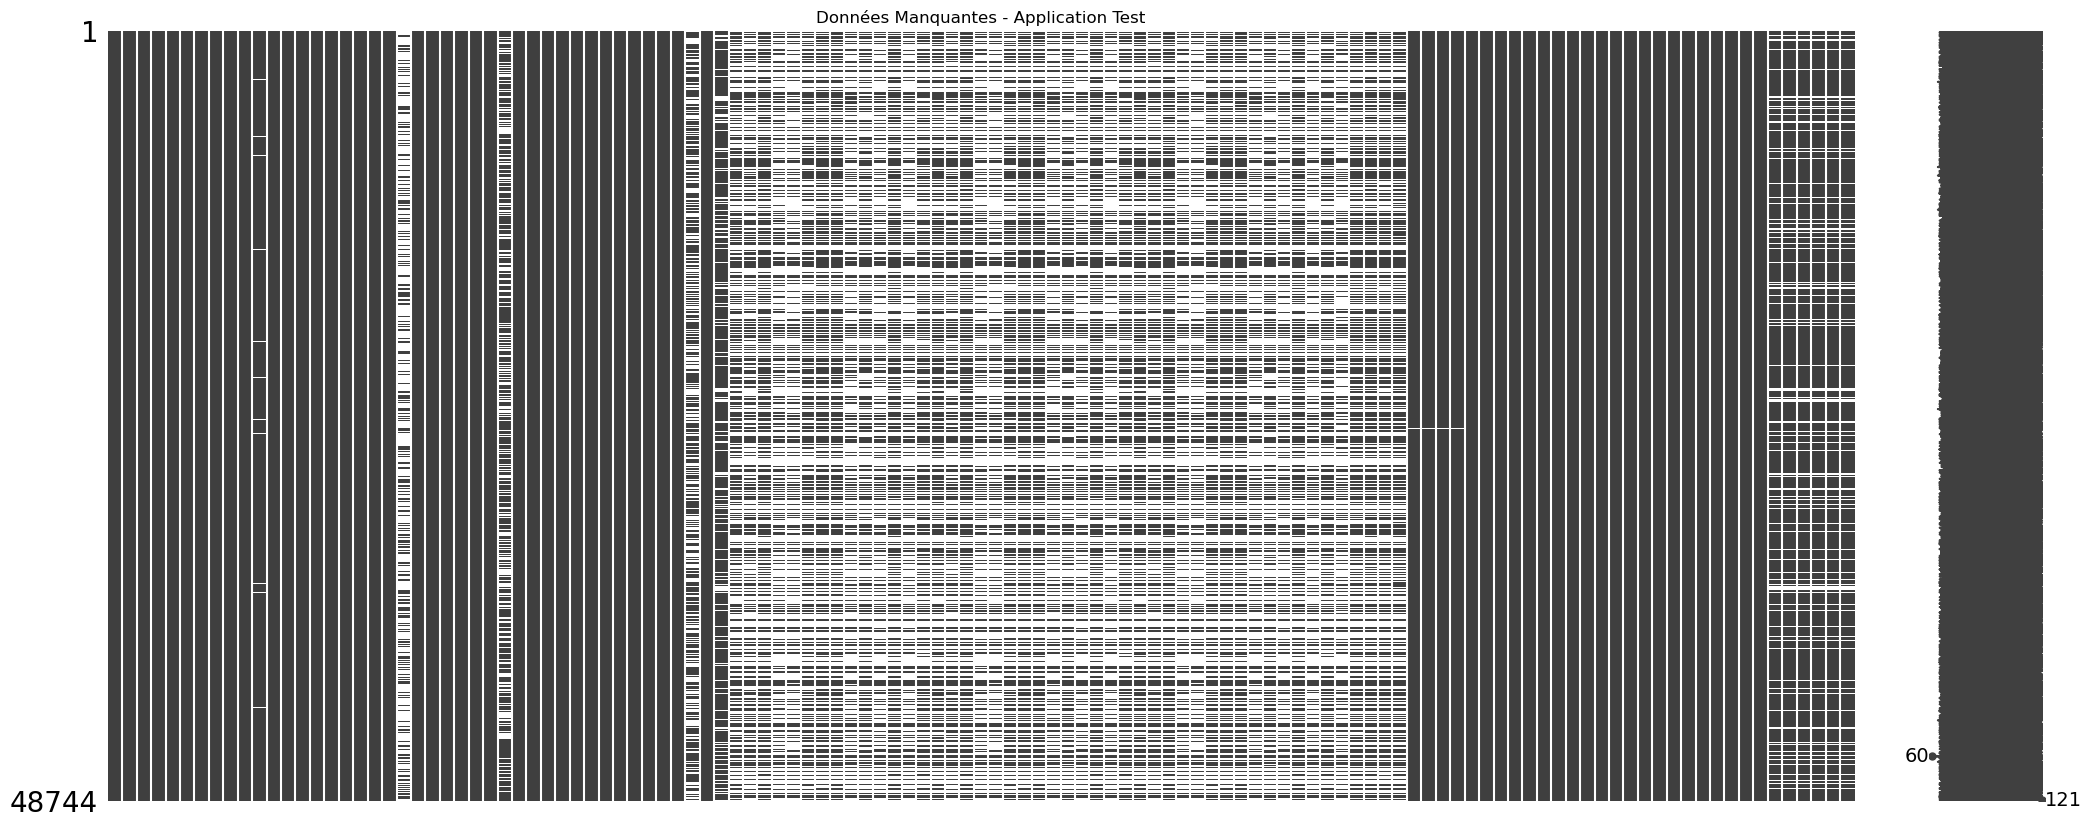

<Figure size 1000x600 with 0 Axes>

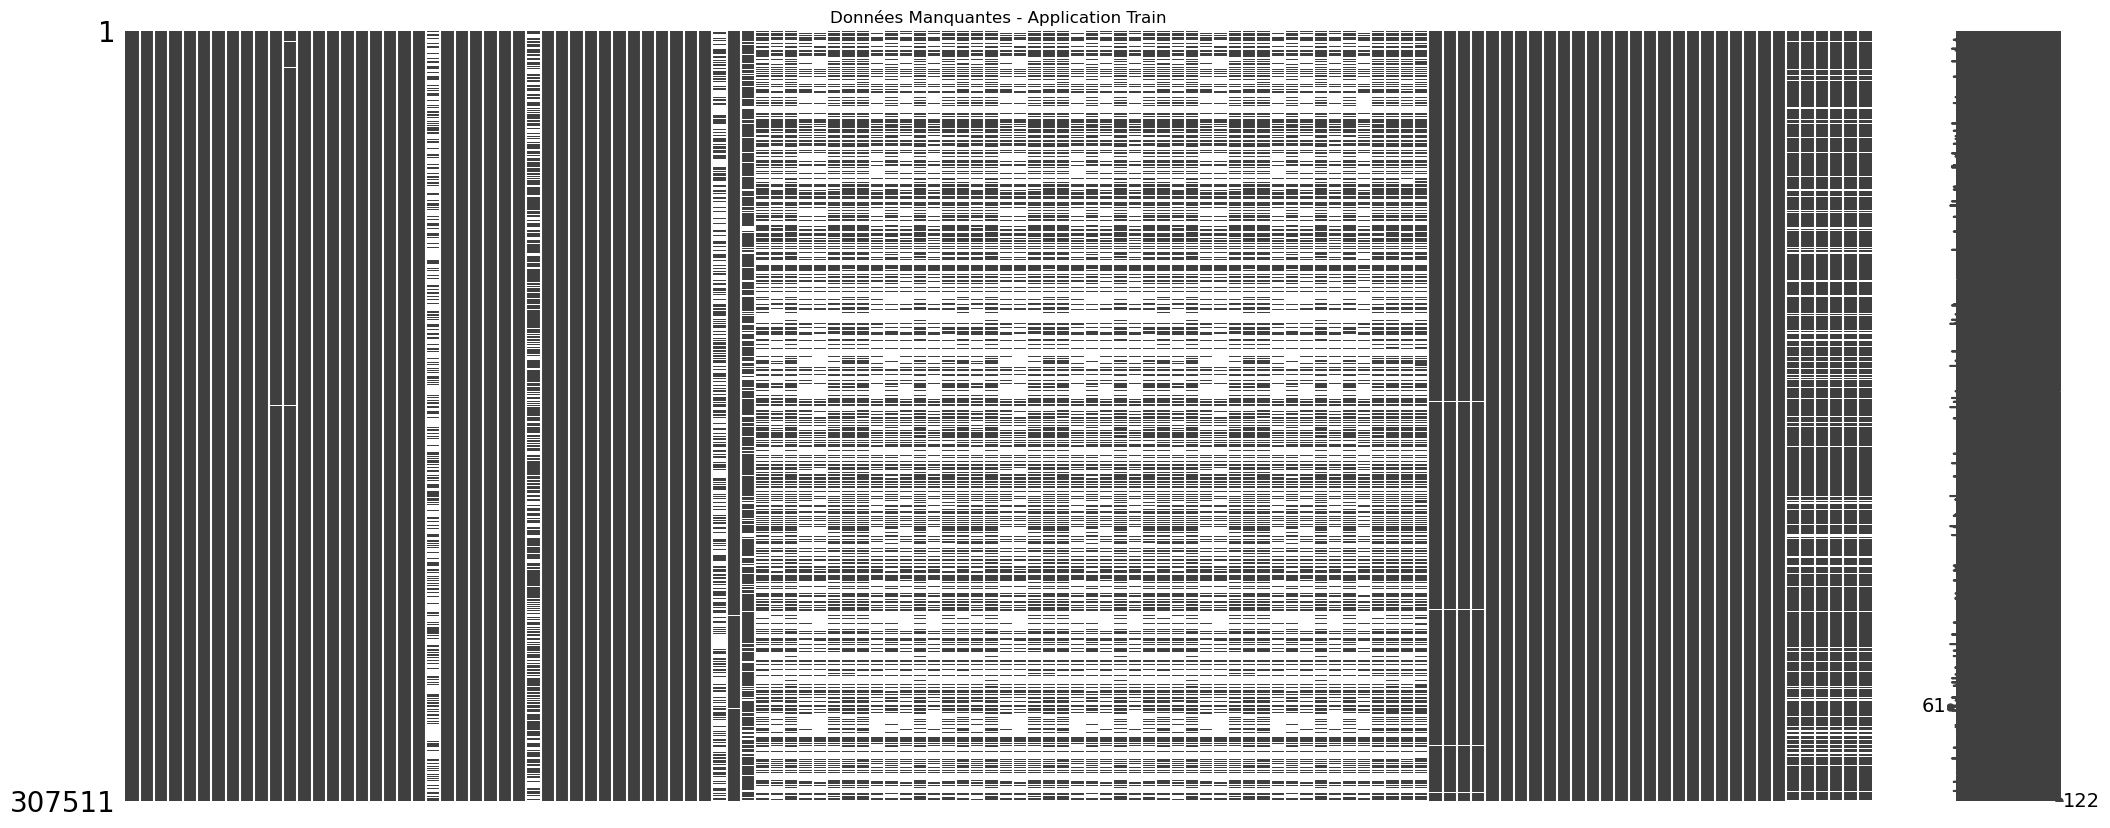

<Figure size 1000x600 with 0 Axes>

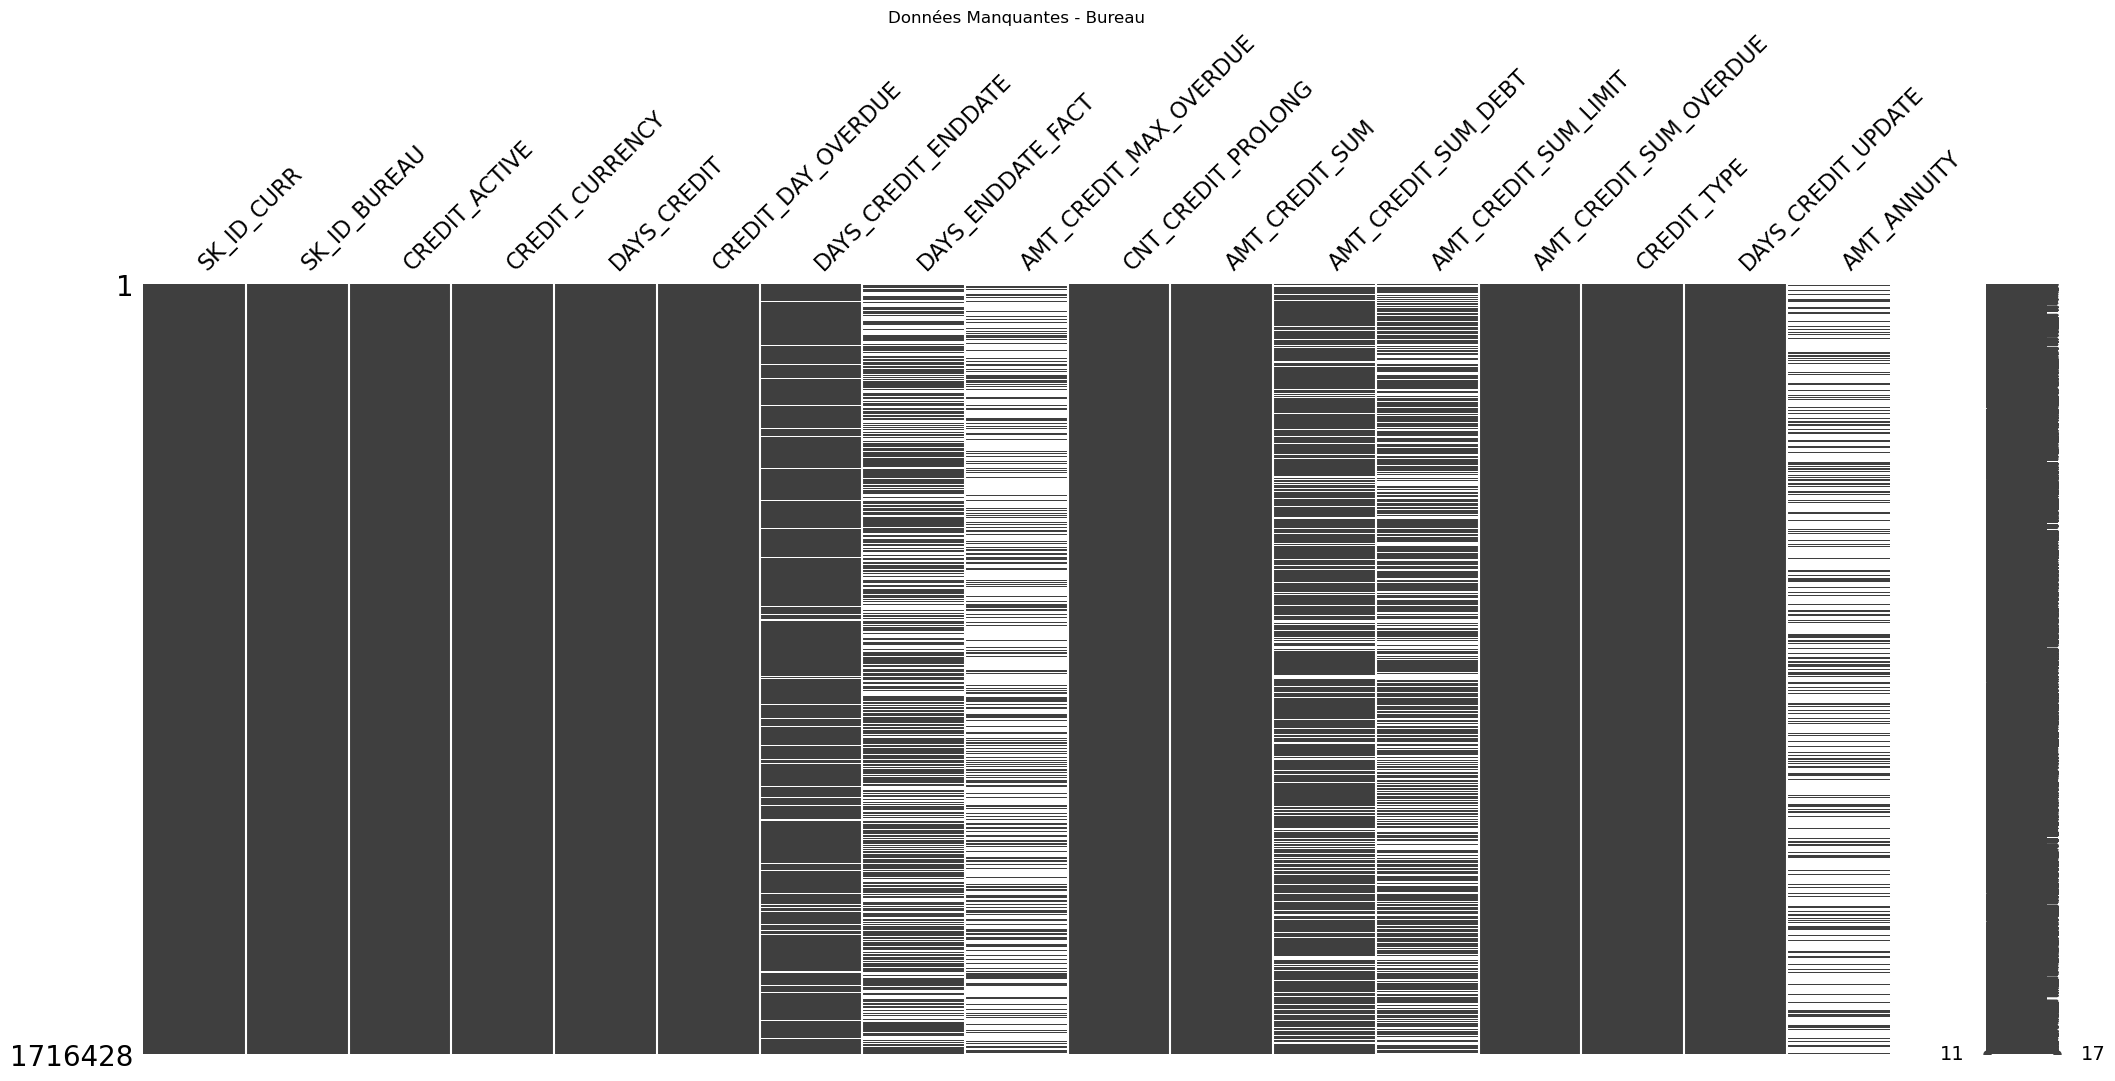

<Figure size 1000x600 with 0 Axes>

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\image.py:181: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


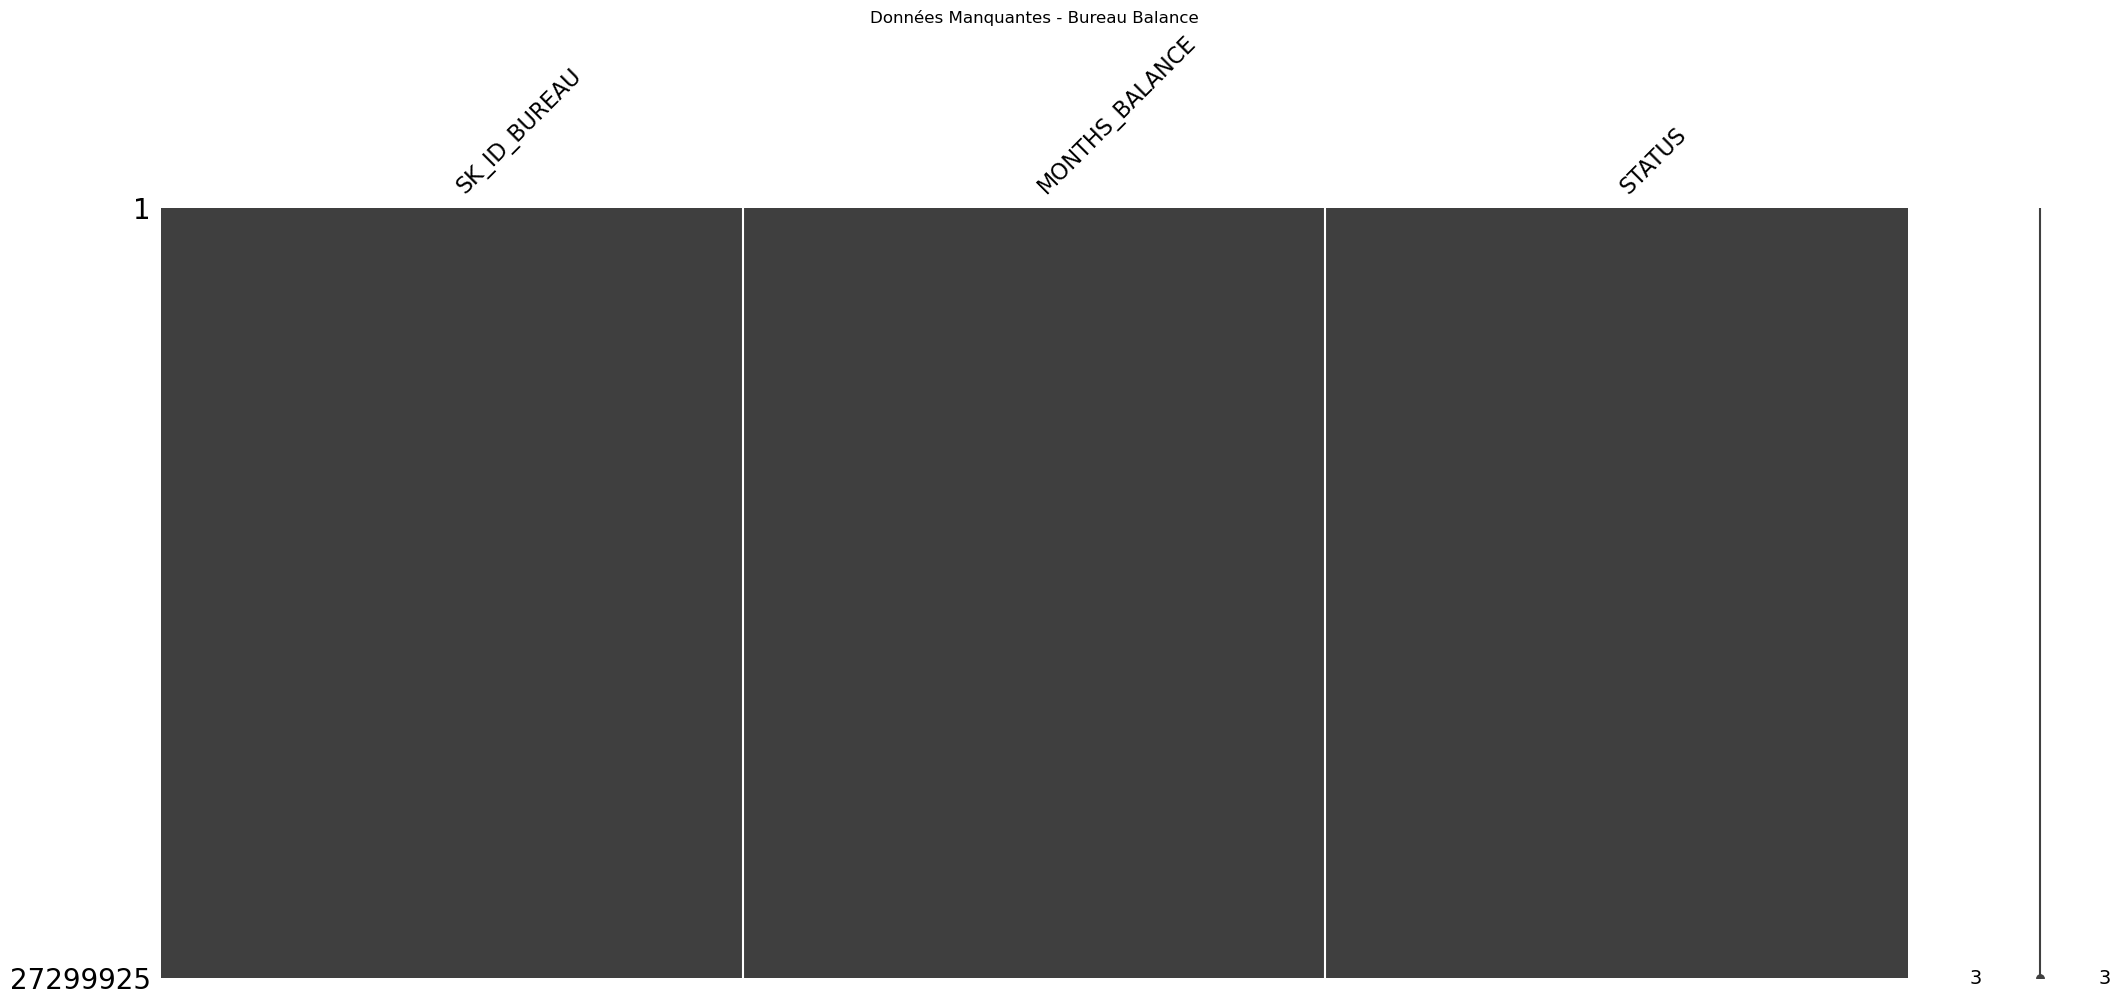

<Figure size 1000x600 with 0 Axes>

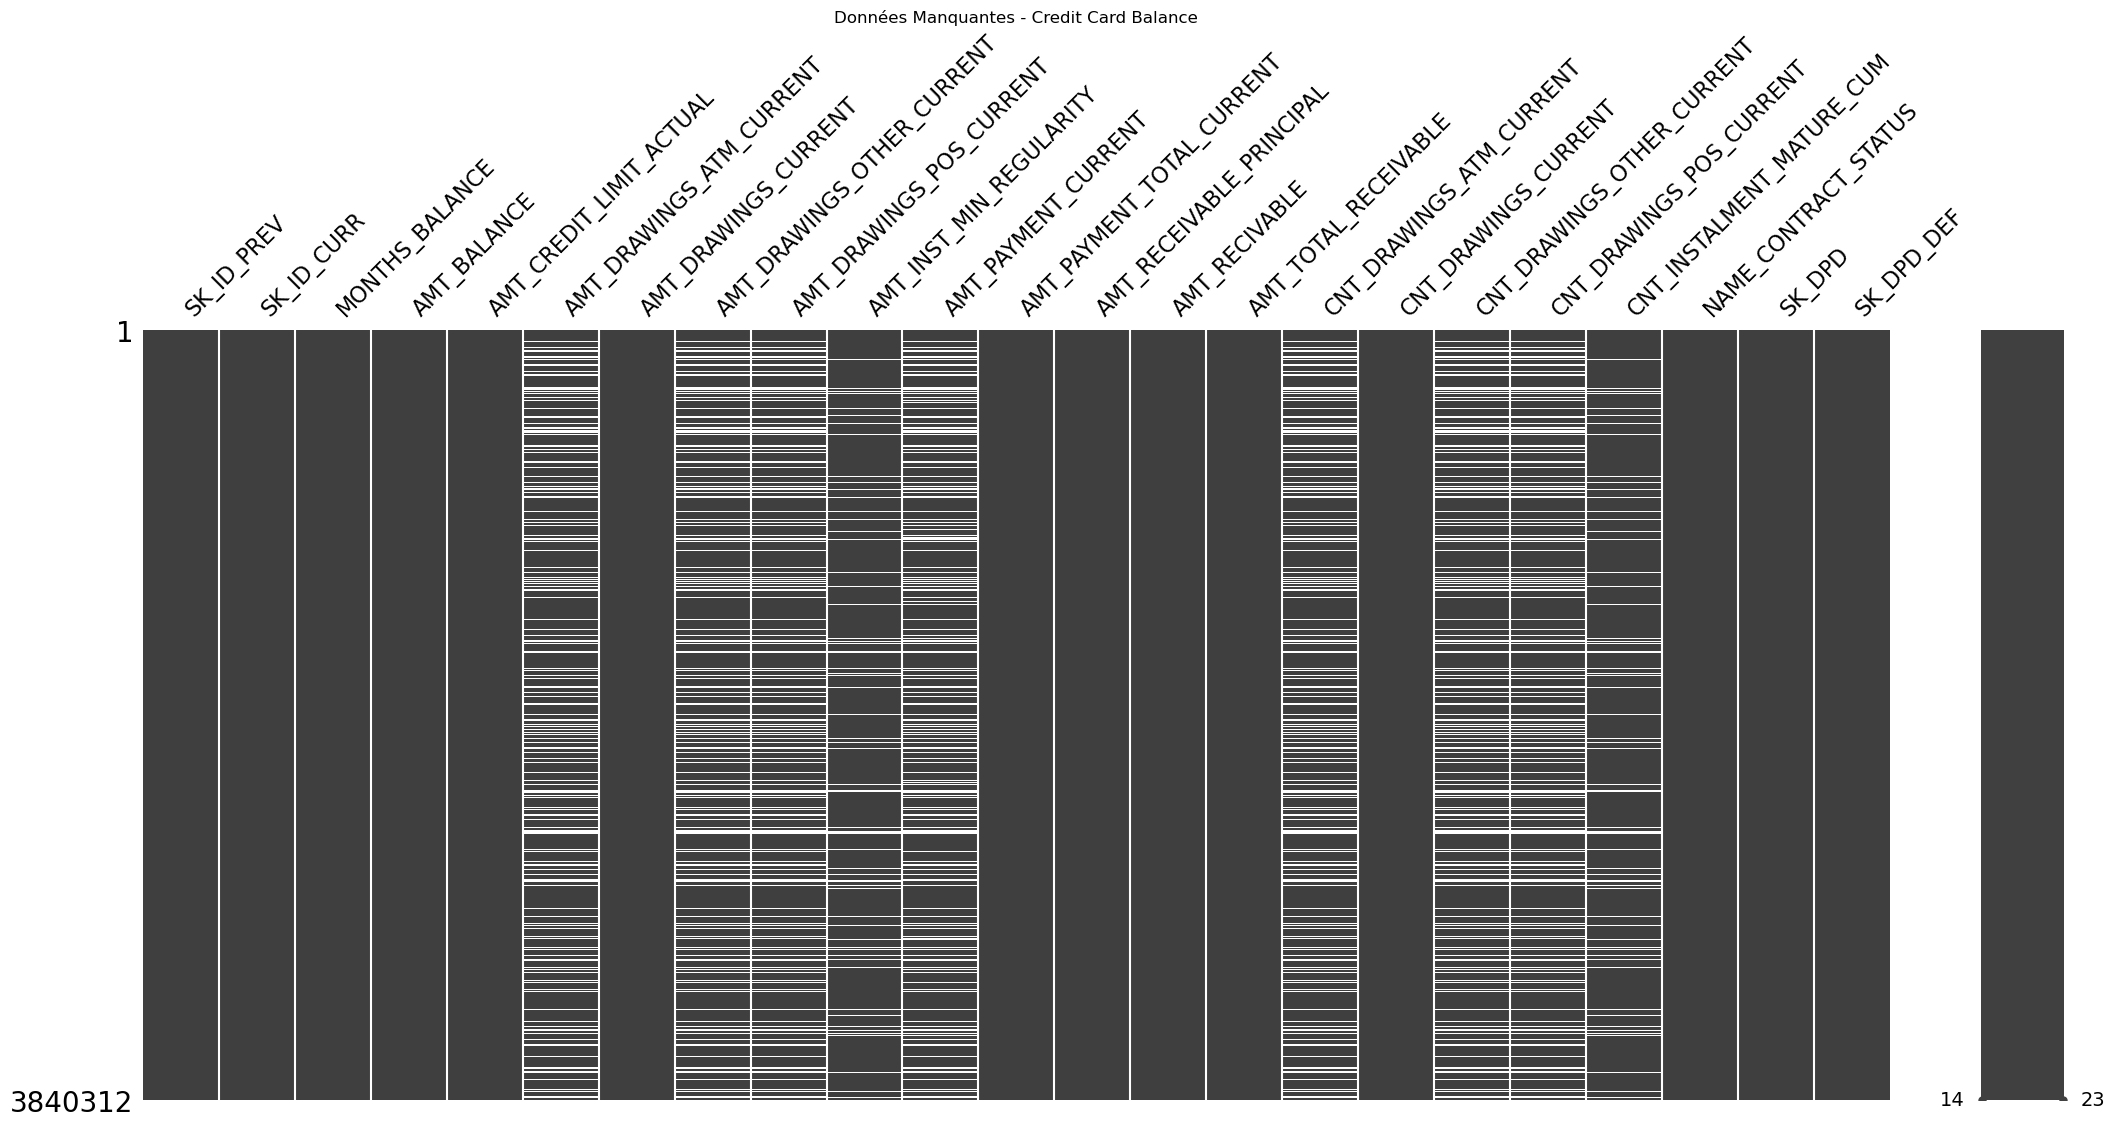

<Figure size 1000x600 with 0 Axes>

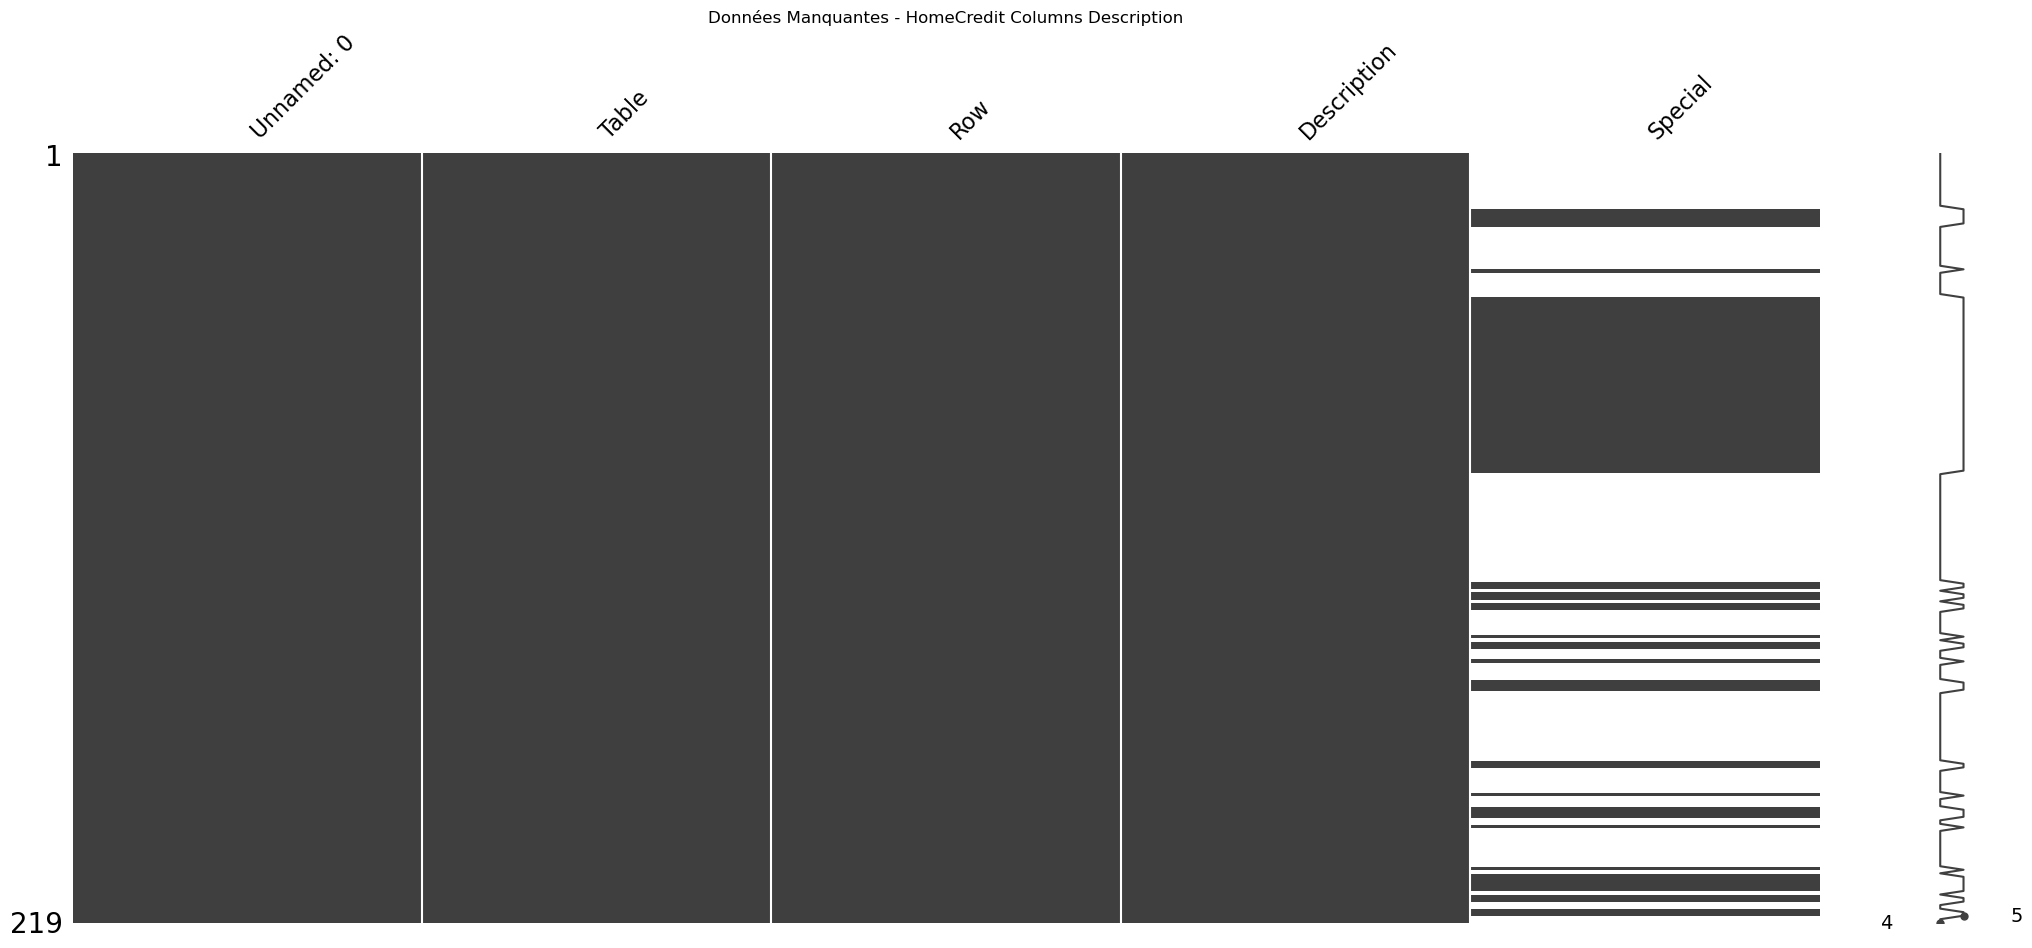

<Figure size 1000x600 with 0 Axes>

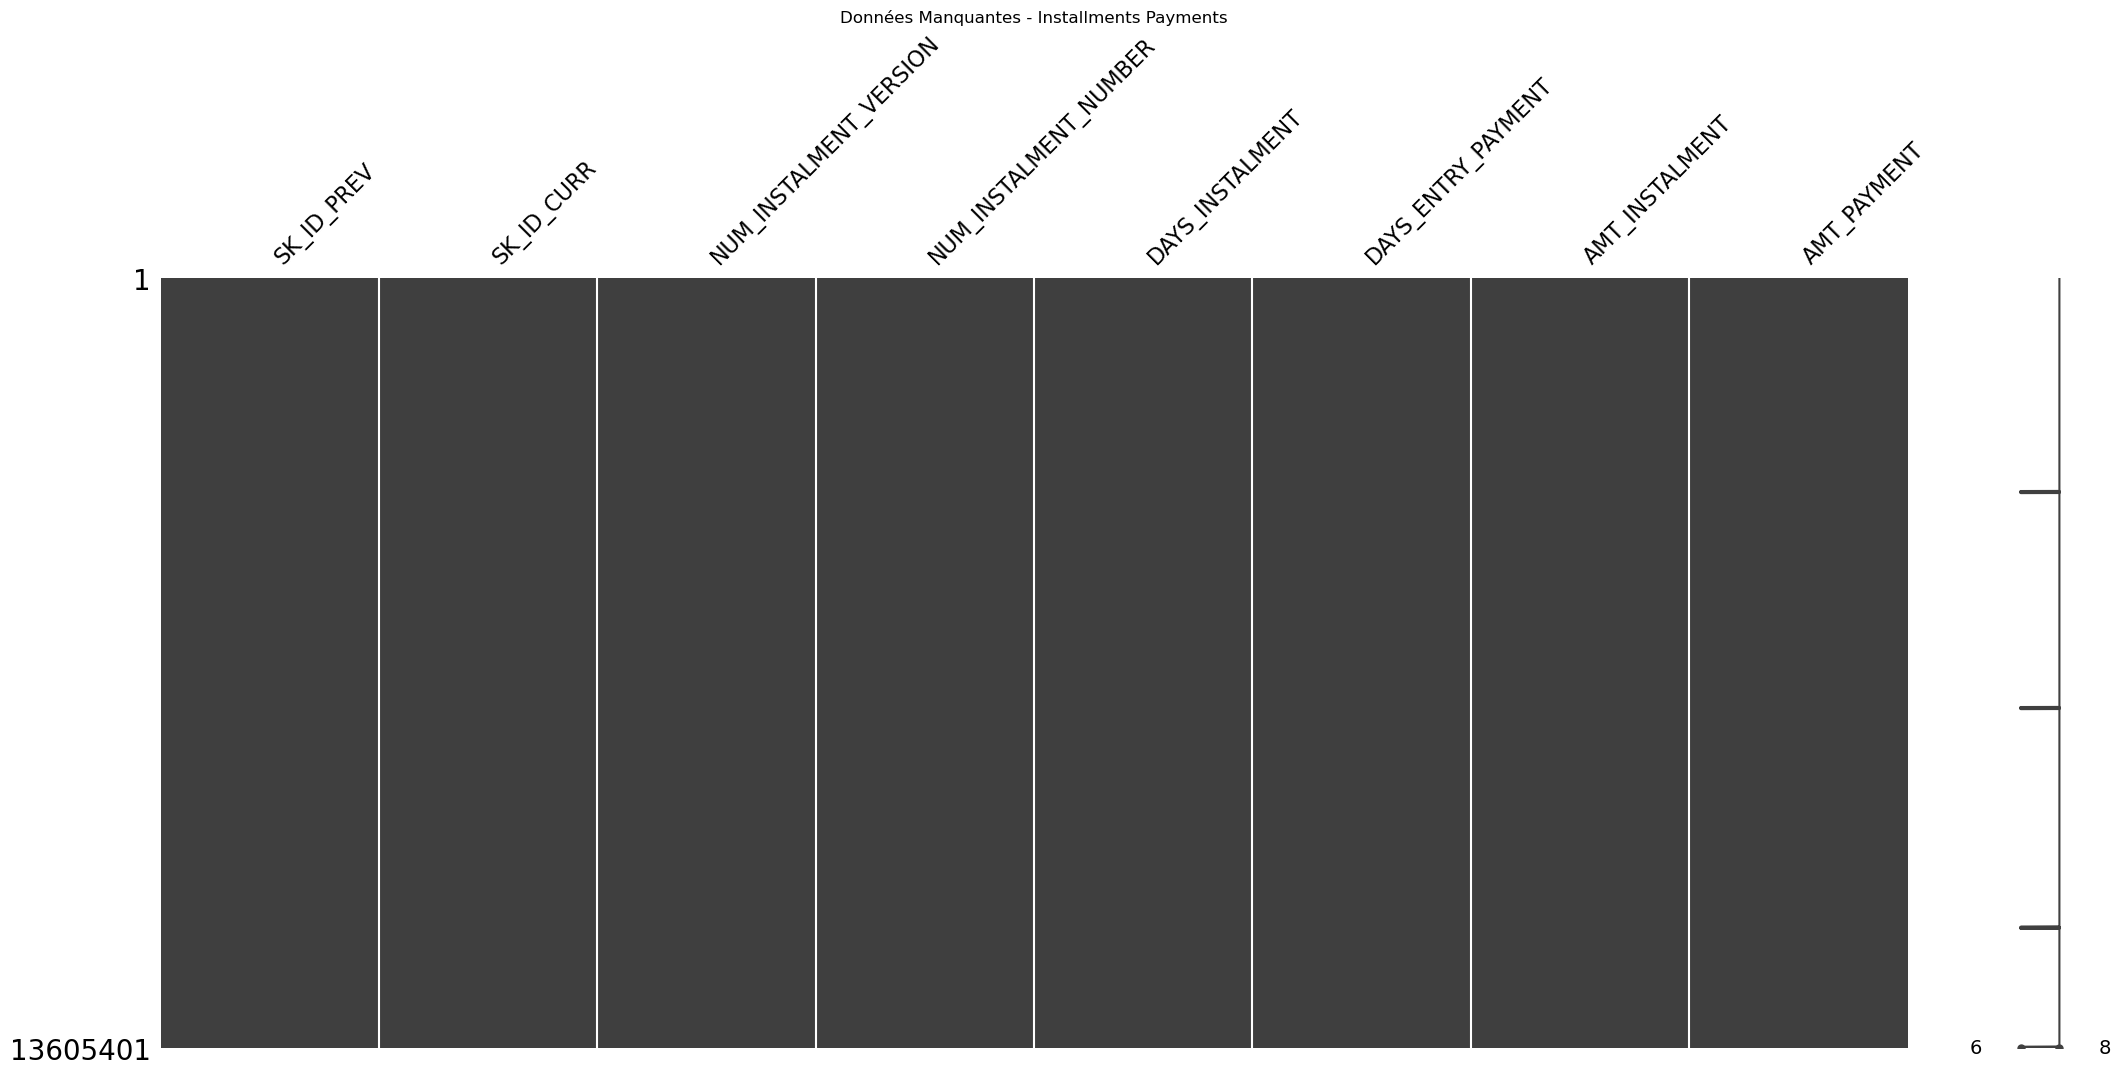

<Figure size 1000x600 with 0 Axes>

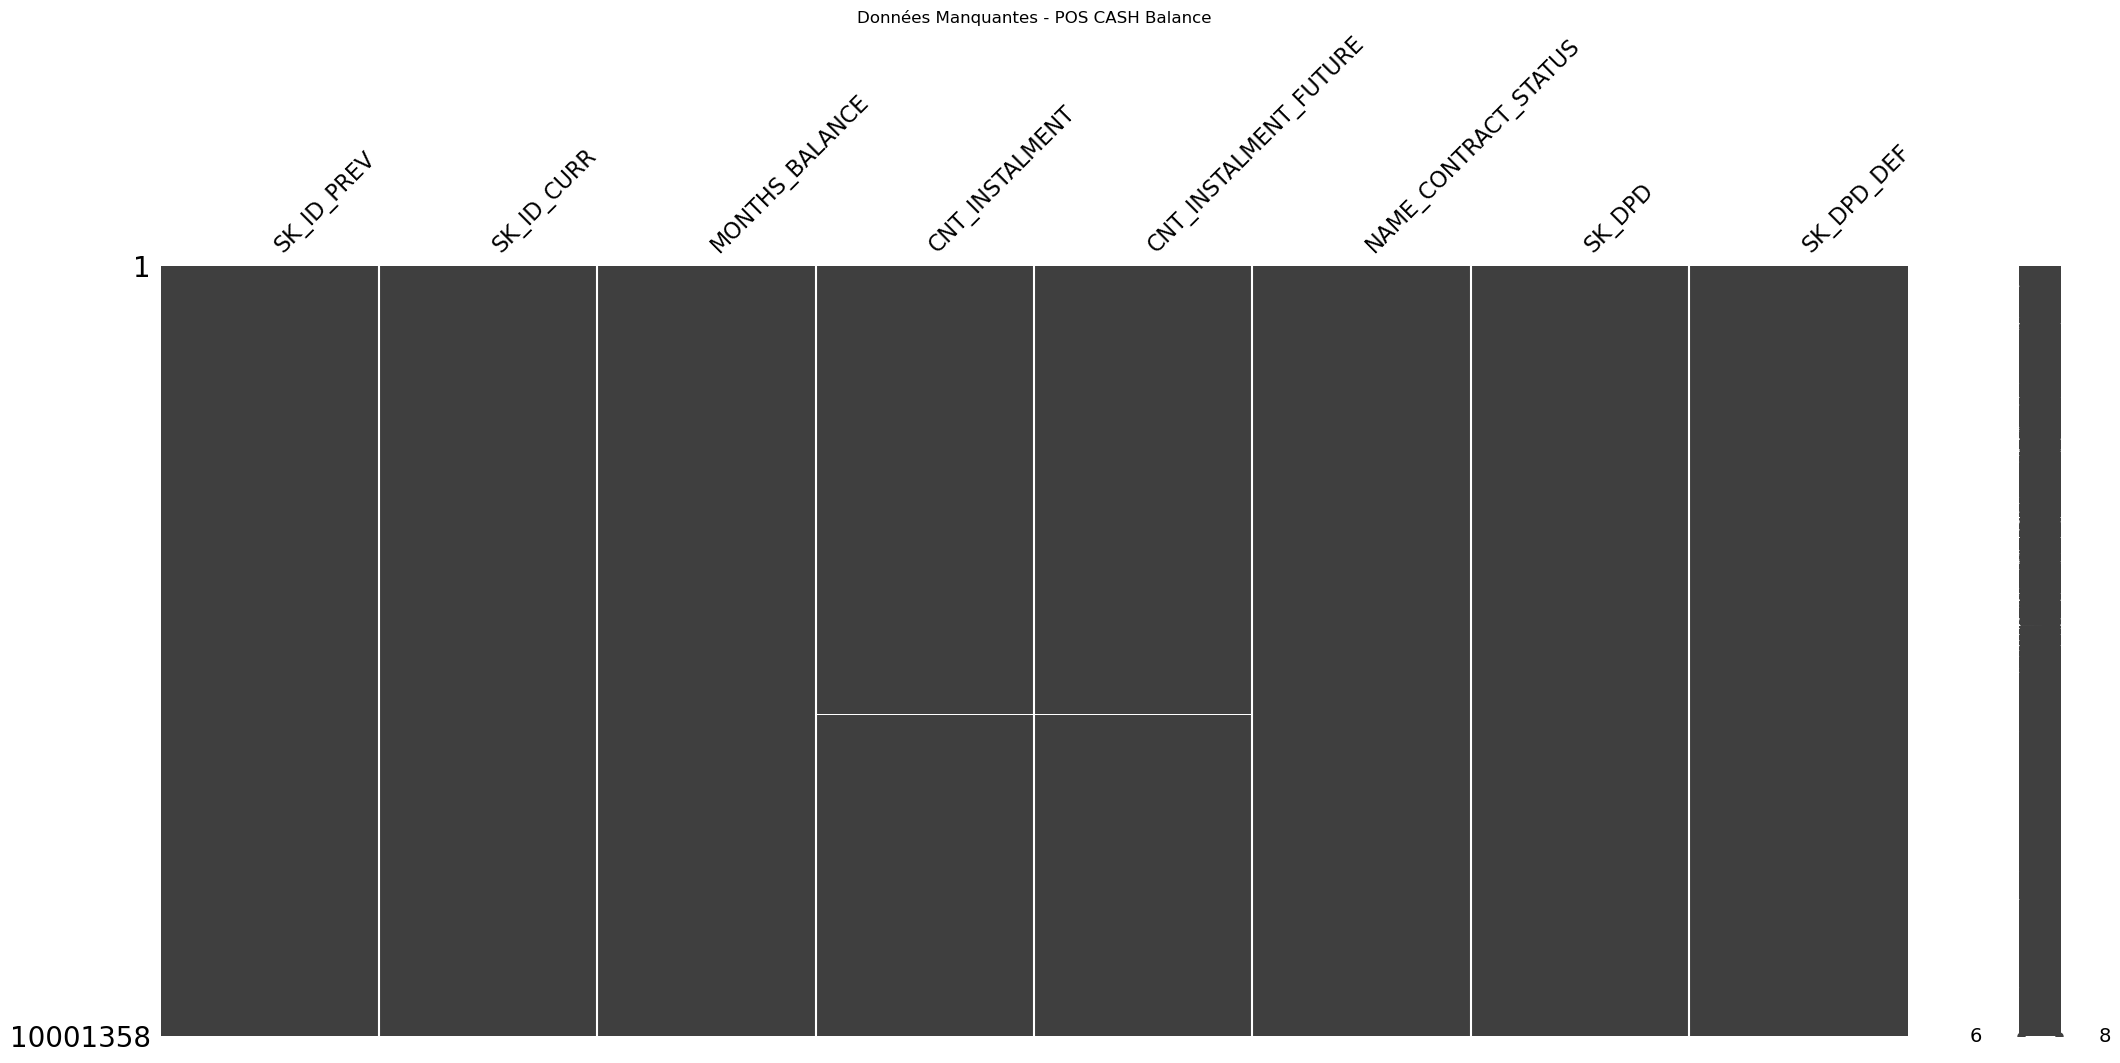

<Figure size 1000x600 with 0 Axes>

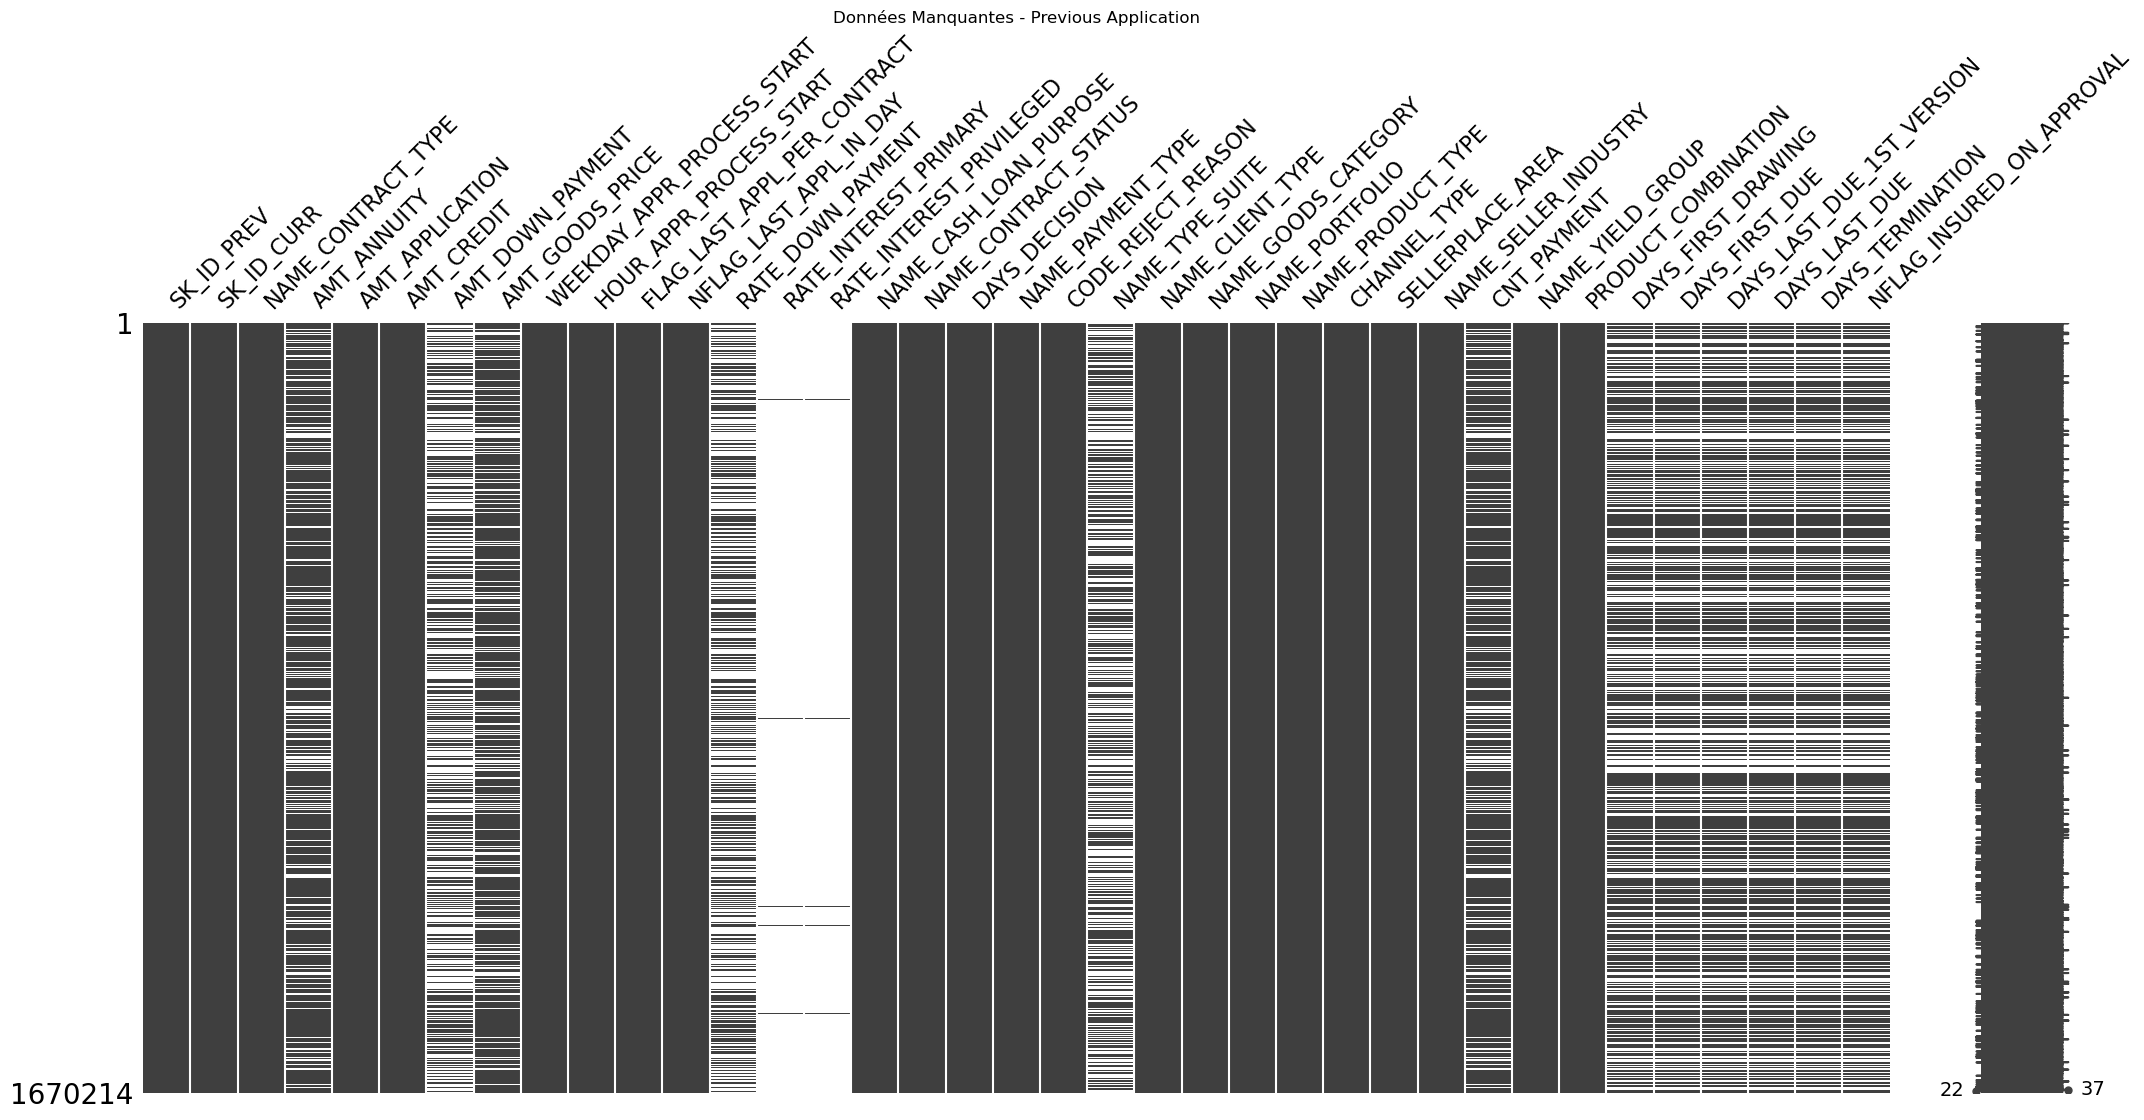

<Figure size 1000x600 with 0 Axes>

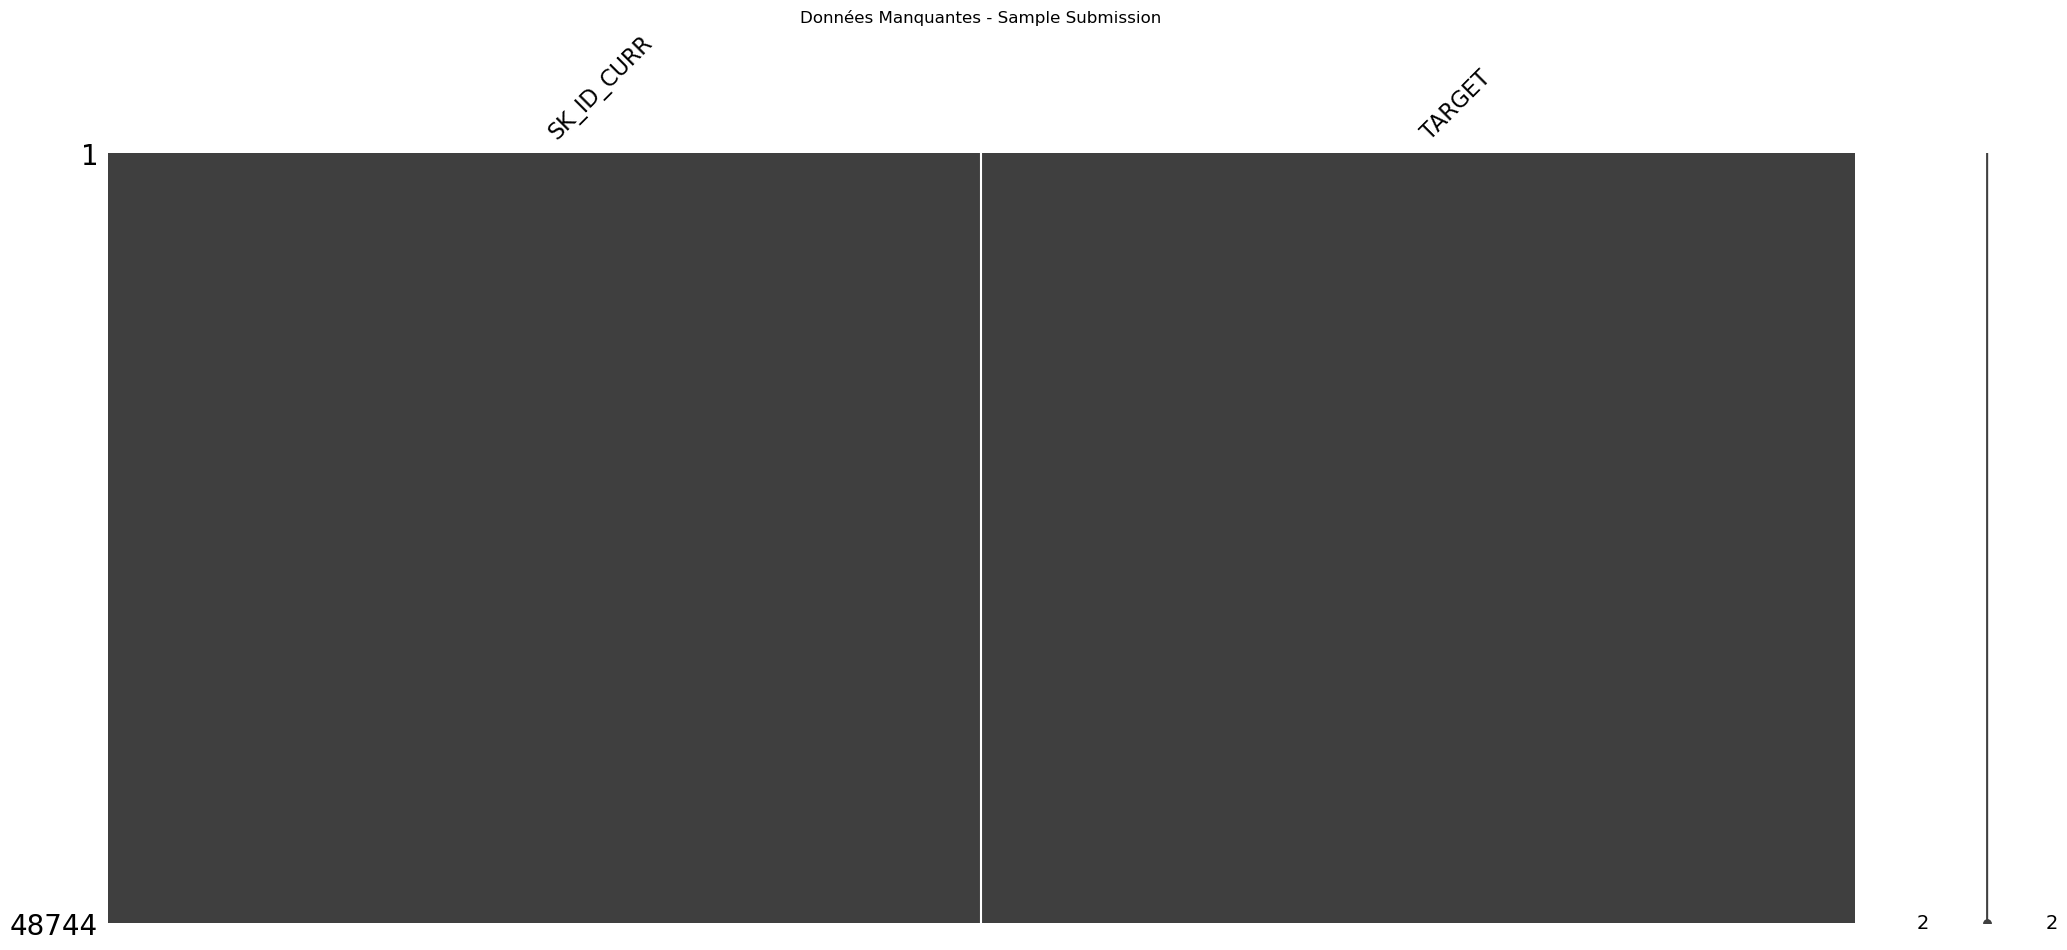

In [9]:
# Importation des fichiers csv / création des dataframes
df_app_test = pd.read_csv('application_test.csv')
df_app_train = pd.read_csv('application_train.csv')
df_bureau = pd.read_csv('bureau.csv')
df_bureau_bal = pd.read_csv('bureau_balance.csv')
df_cc_bal = pd.read_csv('credit_card_balance.csv')
df_col_describe = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')
df_inst_paymts = pd.read_csv('installments_payments.csv')
df_poh_cash = pd.read_csv('POS_CASH_balance.csv')
df_prev_app = pd.read_csv('previous_application.csv')
df_smp_sub = pd.read_csv('sample_submission.csv')

# Liste des dataframes et leurs noms
dataframes = [
    ('Application Test', df_app_test),
    ('Application Train', df_app_train),
    ('Bureau', df_bureau),
    ('Bureau Balance', df_bureau_bal),
    ('Credit Card Balance', df_cc_bal),
    ('HomeCredit Columns Description', df_col_describe),
    ('Installments Payments', df_inst_paymts),
    ('POS CASH Balance', df_poh_cash),
    ('Previous Application', df_prev_app),
    ('Sample Submission', df_smp_sub)
]

# Boucle pour afficher les graphiques des données manquantes
for name, df in dataframes:
    plt.figure(figsize=(10, 6))
    msno.matrix(df)
    plt.title(f'Données Manquantes - {name}')
    plt.show()
 

### 5. Description des tables & des colonnes

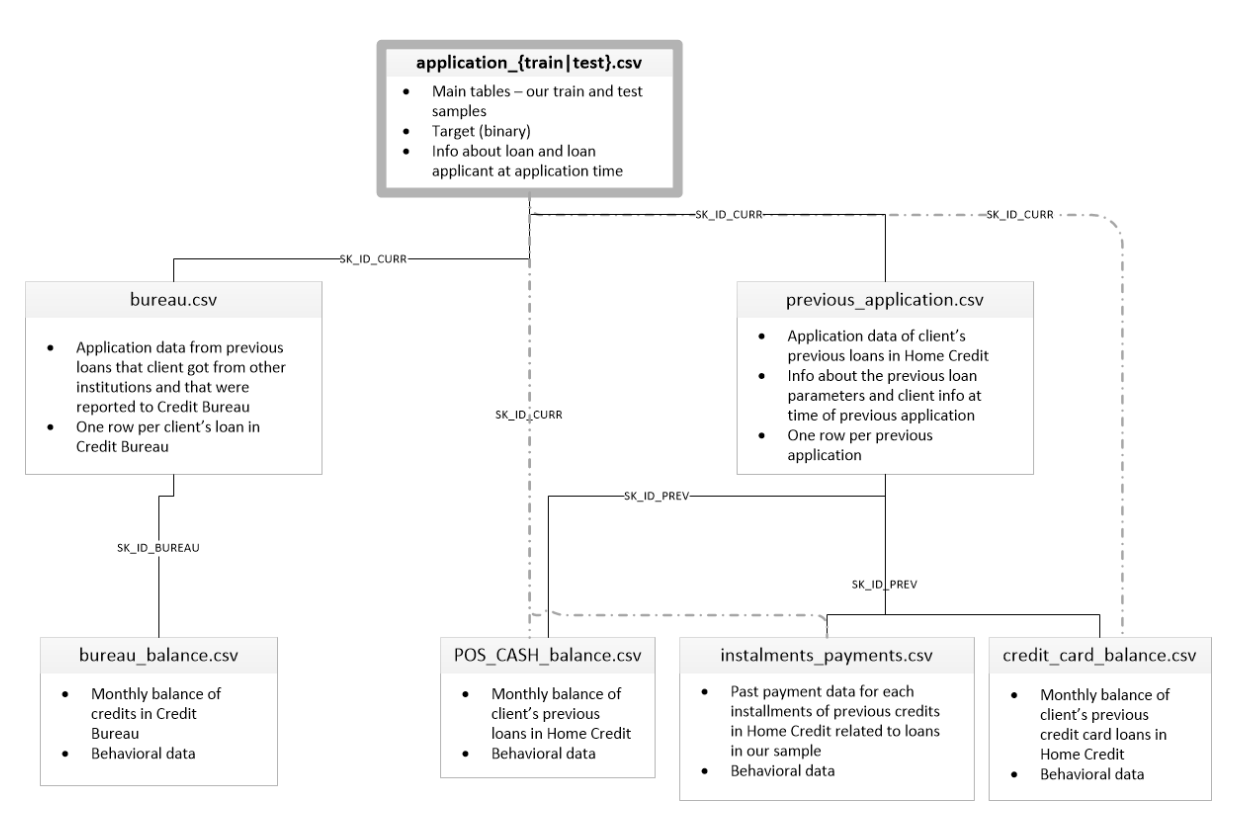

#### a. application_train and application_test


- Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
- Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

#### b. bureau_balance

- Soldes mensuels des crédits antérieurs dans les bureaux de crédit.
- Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit antérieur signalé au bureau de crédit - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits antérieurs relatifs * # de mois où nous avons un historique observable pour les crédits antérieurs) lignes.

#### c. bureau

- Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
- Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans Credit Bureau avant la date de la demande.

#### d. POS_CASH_balance

- Instantanés des soldes mensuels des crédits POS (point de vente) et des crédits de trésorerie antérieurs que le demandeur a contractés auprès de Home Credit.
- Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit antérieur auprès de Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits antérieurs relatifs * # de mois dans lesquels nous disposons d'un historique observable pour les crédits antérieurs) lignes.

#### e. credit_card_balance

- Instantanés mensuels des soldes des cartes de crédit antérieures que le demandeur possède auprès de Home Credit.
- Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit antérieur auprès de Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de cartes de crédit antérieures relatives * # de mois où nous disposons d'un historique observable pour la carte de crédit antérieure) des lignes.

#### f. previous_application

- Toutes les demandes antérieures de prêts au logement des clients qui ont des prêts dans notre échantillon.
- Il y a une ligne pour chaque demande antérieure liée à des prêts dans notre échantillon de données.

#### g. installments_payments

- Historique des remboursements pour les crédits précédemment décaissés dans Home Credit liés aux prêts de notre échantillon.
- Il y a a) une ligne pour chaque paiement effectué et b) une ligne pour chaque paiement manqué.
- Une ligne équivaut à un paiement d'une mensualité OU à une mensualité correspondant à un paiement d'un précédent crédit à domicile lié aux prêts de notre échantillon.

#### h. HomeCredit_columns_description

- Ce fichier contient les descriptions des colonnes des différents fichiers de données

## B. EDA

*Sourcing at this notebook on kaggle for the EDA :*
- https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Exploratory-Data-Analysis
- Author : RISHABH RAO

### 1. La variable cible

La cible est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

In [6]:
# Répartition de la valeur cible
df_app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

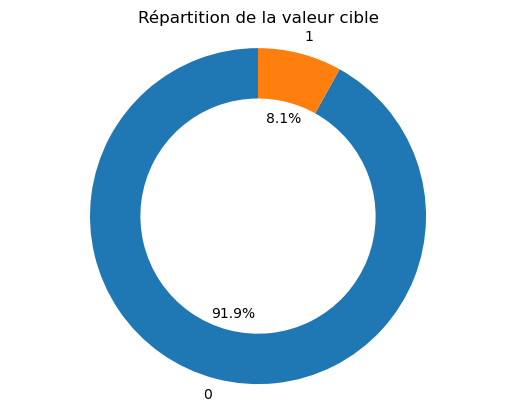

In [9]:
# Valeur cible comtpage des valeurs
target_counts = df_app_train['TARGET'].value_counts()

# Création d'un diagramme circulaire
fig, ax = plt.subplots()
ax.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
ax.axis('equal')  

# Titre
plt.title("Répartition de la valeur cible")

# Afficher le graph'
plt.show()

*Commentaires :*

Ces informations montrent qu'il s'agit d'un problème de classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes en fonction de leur représentation dans les données afin de refléter ce déséquilibre.

### 2. Examen des outliers

#### i. Les âges

In [10]:
# Describe sur la variable des âges transformée en année
(df_app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les âges semblent cohérents sans valeurs dites aberrantes.

#### ii. Les périodes de chômage

In [15]:
# Describe sur la variable du temps au chômage
(df_app_train['DAYS_EMPLOYED'] / 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Nous sommes dans la situation où nous avons des valeurs aberrantes (max à 1000 ans et une moyenne à 174 ans)

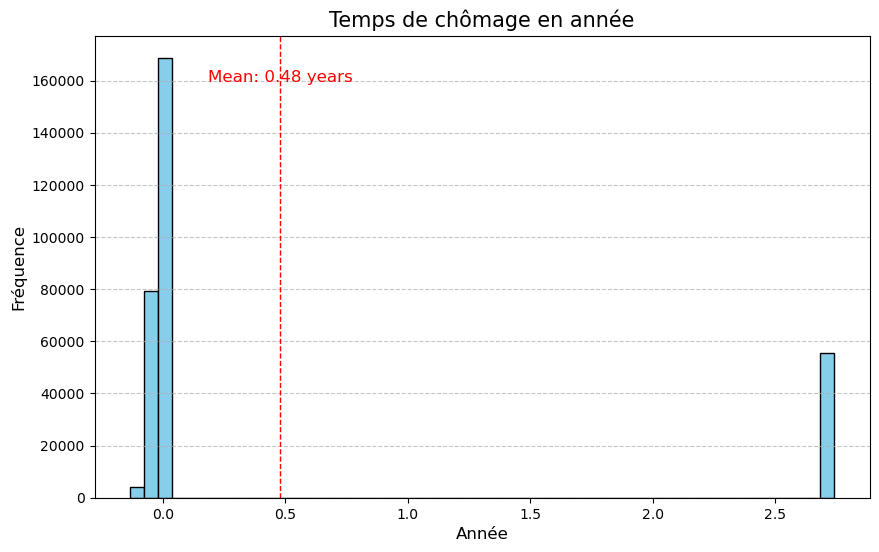

In [21]:
# Transformer la variable en année
df_app_train['DAYS_EMPLOYED'] = df_app_train['DAYS_EMPLOYED'] / 365

# Création d'un histogramme 
plt.figure(figsize=(10, 6))
plt.hist(df_app_train['DAYS_EMPLOYED'], bins=50, edgecolor='black', color='skyblue')
plt.title('Temps de chômage en année', fontsize=15)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajout de la ligne 'moyenne'
mean_value = df_app_train['DAYS_EMPLOYED'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_value, plt.ylim()[1]*0.9, f'Mean: {mean_value:.2f} years', color='red', fontsize=12, ha='center')

# afficher le graph'
plt.show()


Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [25]:
# Sélectionner les lignes du DataFrame où la colonne 'DAYS_EMPLOYED' est égale à 365243 (valeur anormale)
anom = df_app_train[df_app_train['DAYS_EMPLOYED'] == 365243]

# Sélectionner les lignes du DataFrame où la colonne 'DAYS_EMPLOYED' est différente de 365243 (valeur normale)
non_anom = df_app_train[df_app_train['DAYS_EMPLOYED'] != 365243]

# Calculer et afficher le pourcentage de défauts de paiement pour les valeurs normales
print('Les non-anomalies sont en défaut sur %0.2f%% des prêts' % (100 * non_anom['TARGET'].mean()))

# Calculer et afficher le pourcentage de défauts de paiement pour les valeurs anormales
print('Les anomalies sont en défaut sur %0.2f%% des prêts' % (100 * anom['TARGET'].mean()))

# Afficher le nombre de lignes avec des jours d'emploi anormaux
print('Il y a %d jours d\'emploi anormaux' % len(anom))


Les non-anomalies sont en défaut sur 8.07% des prêts
Les anomalies sont en défaut sur nan% des prêts
Il y a 0 jours d'emploi anormaux


Voilà qui est extrêmement intéressant ! Il s'avère que les anomalies ont un taux de défaillance plus faible.

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous remplirons les valeurs anormales avec not a number (np.nan) et créerons ensuite une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

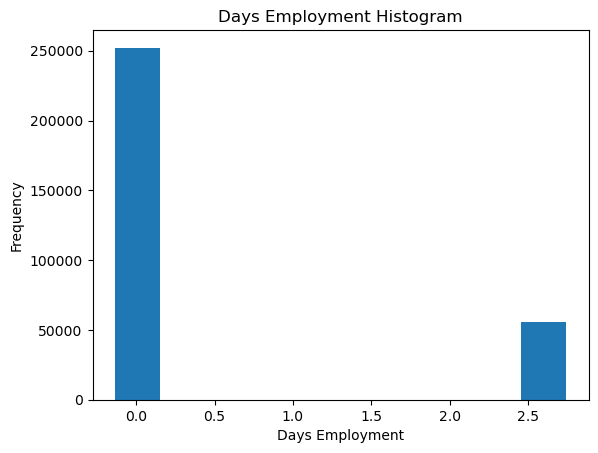

In [33]:
# Create an anomalous flag column
df_app_train['DAYS_EMPLOYED_ANOM'] = df_app_train["DAYS_EMPLOYED"]*365
df_app_train['DAYS_EMPLOYED_ANOM'] = df_app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une certaine valeur, probablement la médiane de la colonne). Les autres colonnes contenant des jours dans le cadre de données semblent correspondre à ce que nous attendons et ne présentent pas de valeurs aberrantes évidentes.

In [36]:
df_app_test['DAYS_EMPLOYED_ANOM'] = df_app_test["DAYS_EMPLOYED"] == 365243
df_app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_app_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_app_test)))

There are 0 anomalies in the test data out of 48744 entries


In [44]:
# Définir l'affichage maximal des colonnes
pd.set_option('display.max_columns', None)

# Obtenir la description de toutes les colonnes du DataFrame
description = df_app_test.describe(include='all')

# Afficher le DataFrame avec la description
display(description)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
count    48744.000000              48744       48744        48744   
unique            NaN                  2           2            2   
top               NaN         Cash loans           F            N   
freq              NaN              48305       32678        32311   
mean    277796.676350                NaN         NaN          NaN   
std     103169.547296                NaN         NaN          NaN   
min     100001.000000                NaN         NaN          NaN   
25%     188557.750000                NaN         NaN          NaN   
50%     277549.000000                NaN         NaN          NaN   
75%     367555.500000                NaN         NaN          NaN   
max     456250.000000                NaN         NaN          NaN   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count            48744  48744.000000      4.874400e+04  4.874400e+04   
unique               2           NaN               NaN           NaN   
top                  Y           NaN               NaN           NaN   
freq             33658           NaN               NaN           NaN   
mean               NaN      0.397054      1.784318e+05  5.167404e+05   
std                NaN      0.709047      1.015226e+05  3.653970e+05   
min                NaN      0.000000      2.694150e+04  4.500000e+04   
25%                NaN      0.000000      1.125000e+05  2.606400e+05   
50%                NaN      0.000000      1.575000e+05  4.500000e+05   
75%                NaN      1.000000      2.250000e+05  6.750000e+05   
max                NaN     20.000000      4.410000e+06  2.245500e+06   

          AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
count    48720.000000     4.874400e+04           47833            48744   
unique            NaN              NaN               7                7   
top               NaN              NaN   Unaccompanied          Working   
freq              NaN              NaN           39727            24533   
mean     29426.240209     4.626188e+05             NaN              NaN   
std      16016.368315     3.367102e+05             NaN              NaN   
min       2295.000000     4.500000e+04             NaN              NaN   
25%      17973.000000     2.250000e+05             NaN              NaN   
50%      26199.000000     3.960000e+05             NaN              NaN   
75%      37390.500000     6.300000e+05             NaN              NaN   
max     180576.000000     2.245500e+06             NaN              NaN   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
count                           48744              48744              48744   
unique                              5                  5                  6   
top     Secondary / secondary special            Married  House / apartment   
freq                            33988              32283              43645   
mean                              NaN                NaN                NaN   
std                               NaN                NaN                NaN   
min                               NaN                NaN                NaN   
25%                               NaN                NaN                NaN   
50%                               NaN                NaN                NaN   
75%                               NaN                NaN                NaN   
max                               NaN                NaN                NaN   

        REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
count                 48744.000000  48744.000000   39470.000000   
unique                         NaN           NaN            NaN   
top                            NaN           NaN            NaN   
freq                           NaN           NaN            NaN   
mean                      0.021226 -16068.084605   -2476.738941   
std                       0.014428   4325.900393    2307.963913  

In [48]:
df_col_describe.shape

(219, 5)

# III. Features engineering

*Sourcing on this kaggle notebook :*
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

## 1. Fonction pour l'encodage des variables catégorielles

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=False):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## 2. Pre-process des tables df_app 'test' & 'train'

In [4]:
# Prétraiter application_train.csv et application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Lire les données et les fusionner
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Échantillons d'entraînement : {}, échantillons de test : {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True)
    # Optionnel : supprimer 4 applications avec CODE_GENDER XNA (jeu d'entraînement)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Variables catégorielles avec encodage binaire (0 ou 1 ; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Variables catégorielles avec encodage One-Hot
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Valeurs NaN pour DAYS_EMPLOYED : 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Quelques nouvelles fonctionnalités simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

*Détails du script :*
1. Lecture des fichiers CSV
2. Fusion des données app_train & app_test
3. Filtrage de la colonne 'CODE_GENDER' pour retirer les valeurs 'XNA'
4. Encodage des variables binaire : 'CODE_GENDER, FLAG_OWN_CAR', FLAG_OWN_REALTY'
5. Encodage des variables catégorielles
6. Traitement des valeurs '365243' pour la variable 'DAYS_EMPLOYED, par Nan
7. Features engineering :
- DAYS_EMPLOYED_PERC : ratio des jours employés par rapport à l'âge.
- INCOME_CREDIT_PERC : ratio du revenu total par rapport au crédit.
- INCOME_PER_PERSON : revenu total divisé par le nombre de membres de la famille.
- ANNUITY_INCOME_PERC : ratio de l'annuité par rapport au revenu total.
- PAYMENT_RATE : ratio de l'annuité par rapport au crédit.
8. Nettoyage

Résultat de la fonction :

In [5]:
# Appeler la fonction et stocker le résultat dans un dataframe
df_pre_proc_app = application_train_test()

Échantillons d'entraînement : 307511, échantillons de test : 48744


In [6]:
# Afficher le résultat
df_pre_proc_app.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0  ...                     False                             True   
1  ...                     False                            False   
2  ...                     False                            False   
3  ...                     False                            False   
4  ...                     False                            False   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                      False                    True                    False   
1                      False                    True                    False   
2                      False                   False                    False   
3                      False                   False                    False   
4                      False                   False                    False   

   DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  INCOME_PER_PERSON  \
0            0.067329            0.498036           202500.0   
1            0.070862            0.208736           135000.0   
2            0.011814            0.500000            67500.0   
3            0.159905            0.431748            67500.0   
4            0.152418            0.236842           121500.0   

   ANNUITY_INCOME_PERC  PAYMENT_RATE  
0             0.121978      0.060749  
1             0.132217      0.027598  
2             0.100000      0.050000  
3             0.219900      0.094941  
4             0.179963      0.042623  

[5 rows x 247 columns]

<Axes: >

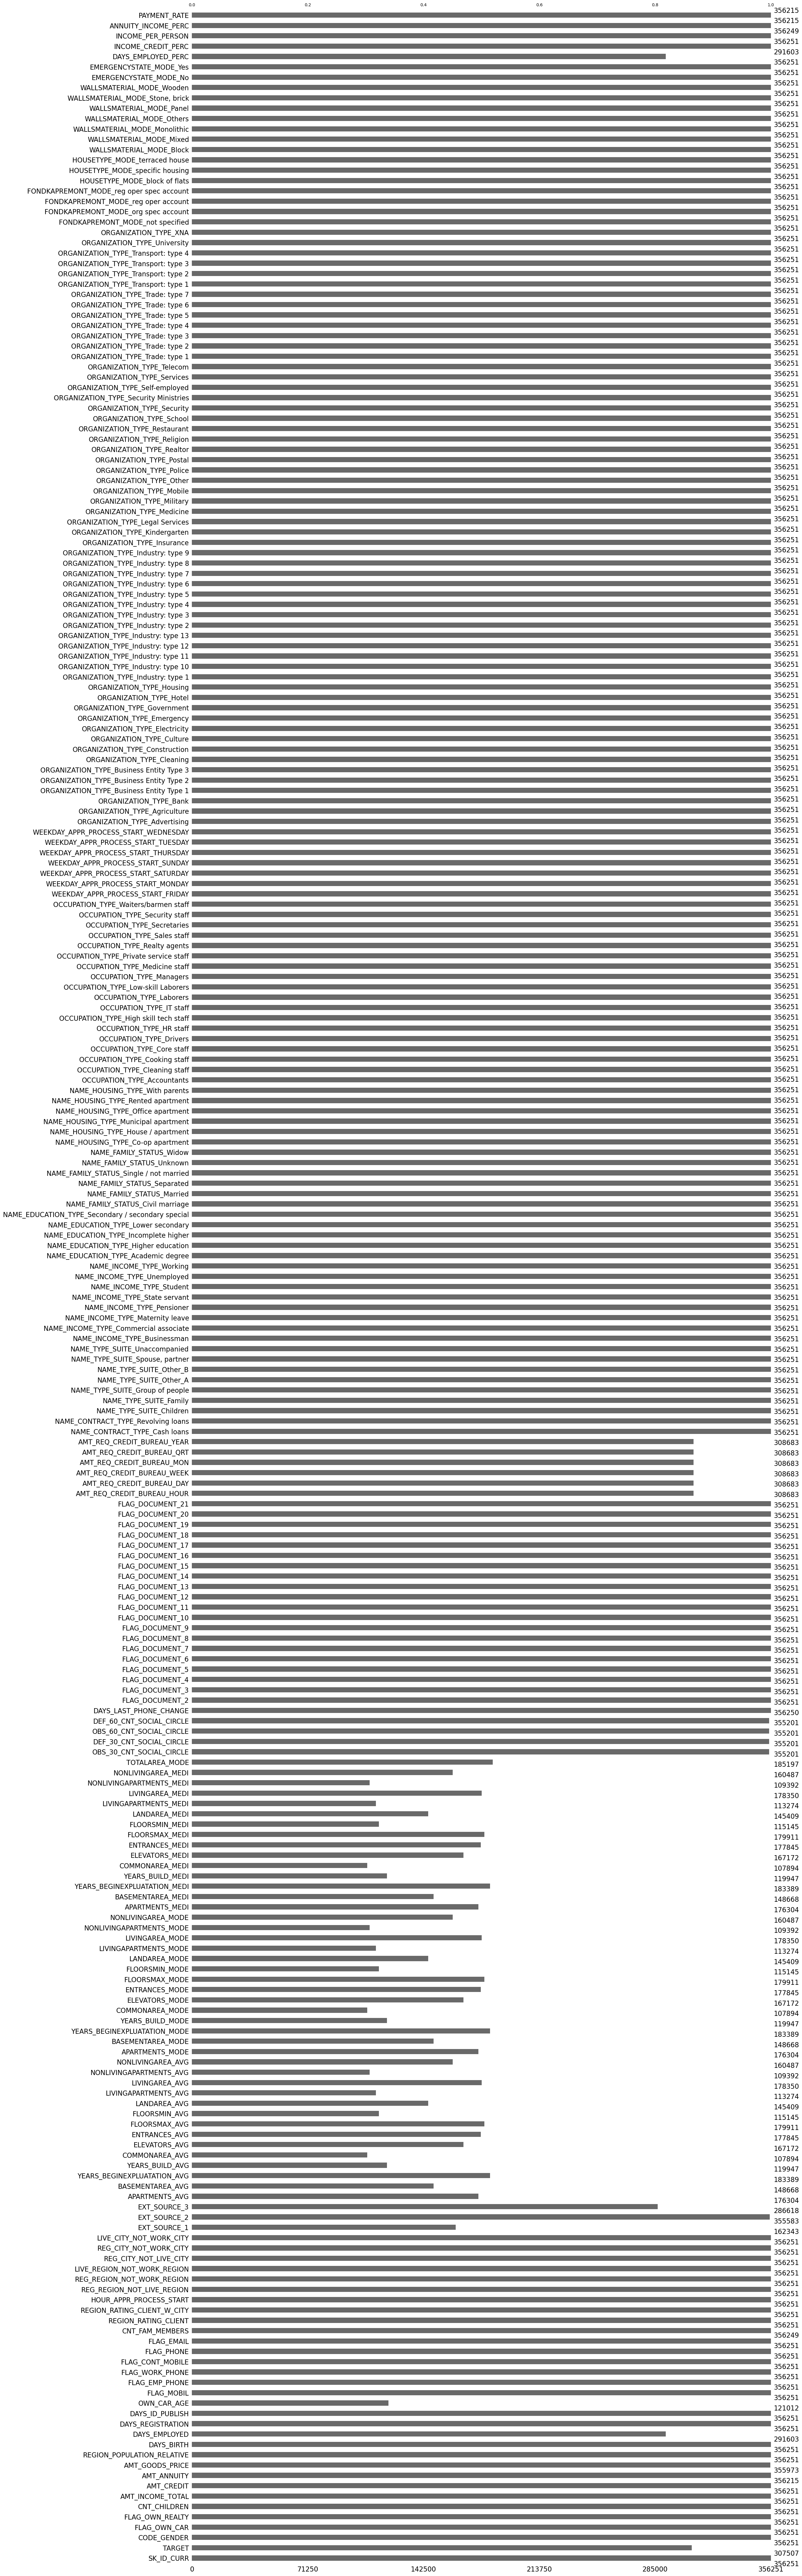

In [7]:
msno.bar(df_pre_proc_app)

## 3. Pre-process des tables bureau et bureau_balance

In [8]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

*Détails du script*
1. Lecture des fichier CSV
2. Encodage des variables catégorielles avec la fonction (booléenne)
3. Agrégation des données de bureau_balance sur "SK_ID_BUREAU", en calculant les statistiques (minimum, maximum, taille) sur la colonne MONTHS_BALANCE et les moyennes sur les colonnes catégorielles.
4. Merge avec la table 'bureau' sur la colonne "SK_ID_BUREAU"
5. Suppression de colonnes et nettoyage
6. Agrégation des données sur SK_ID_CURR
7. Agrégation des crédits actifs et fermés, résultats fusionné dans bureau_agg
8. Retour des données pré-traitées

Résultat de la fonction : 

In [9]:
# Appel de la fonction et stockage du résultat dans une variable
bureau_agg = bureau_and_balance()

In [10]:
# Affichage du résultat
bureau_agg.head(5)

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  ...  \
SK_ID_CURR                                ...   
100001                               0.0  ...   
100002                               0.0  ...   
100003                               0.0  ...   
100004                               0.0  ...   
100005                               0.0  ...   

            CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN  \
SK_ID_CURR                                       
100001                                     0.0   
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100005                                     0.0   

            CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN  CLOSED_AMT_CREDIT_SUM_LIMIT_SUM  \
SK_ID_CURR                                                                      
100001                                   0.0                              0.0   
100002                                   0.0                              0.0   
100003                                   0.0                              0.0   
100004                                   0.0                              0.0   
100005                                   0.0                              0.0   

            CLOSED_AMT_ANNUITY_MAX  CLOSED_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                    
100001                         0.0                      0.0   
100002                         0.0                      0.0   
100003                         NaN                      NaN   
100004                         NaN                      NaN   
100005                         0.0                      0.0   

            CLOSED_CNT_CREDIT_PROLONG_SUM  CLOSED_MONTHS_BALANCE_MIN_MIN  \
SK_ID_CURR                                                                 
100001                                0.0                          -51.0   
100002    

## 4. Pre-process de la table previous_application

In [11]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

*Détails du script*
1. Lecture du fichier CSV
2. Encodage One Hot pour convertir les variables catégorielles
3. Remplacement des valeurs spécifiques : Les valeurs de 365243 dans les colonnes DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, et DAYS_TERMINATION sont remplacées par NaN. Cela est fait pour traiter des valeurs spéciales indiquant des valeurs manquantes.
4. Ajout d'une nouvelle caractéristique : APP_CREDIT_PERC est ajoutée, représentant le pourcentage de la valeur demandée par rapport à la valeur de crédit (AMT_APPLICATION / AMT_CREDIT).
5. Définition des agrégations dans un dictionnaire pour les variables catégorielles
6. Agrégation des données sur 'SK_ID_CURR', nouvelle colonne avec le préfixe 'PREV'
7. Agrégation des applications approuvées (NAME_CONTRACT_STATUS_Approved == 1) sont filtrées et agrégées séparément. Les nouvelles colonnes sont nommées avec le préfixe APPROVED_
8. Agrégation des applications refusées: Les applications refusées (NAME_CONTRACT_STATUS_Refused == 1) sont filtrées et agrégées séparément. Les nouvelles colonnes sont nommées avec le préfixe REFUSED_.
9. Nettoyge des données
10. Retourne les données agrégées dans le dataframe prev_agg

Résultat de la fonction :

In [12]:
df_prev_agg = previous_applications()

In [13]:
df_prev_agg.head(5)

PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000               3951.000   
100002                  9251.775              9251.775               9251.775   
100003                  6737.310             98356.995              56553.990   
100004                  5357.250              5357.250               5357.250   
100005                  4813.200              4813.200               4813.200   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                       24835.50              23787.0   
100002                      179055.00             179055.0   
100003                      435436.50              68053.5   
100004                       24282.00              20106.0   
100005                       22308.75                  0.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   

            PREV_APP_CREDIT_PERC_MIN  ...  \
SK_ID_CURR                            ...   
100001                      1.044079  ...   
100002                      1.000000  ...   
100003                      0.868825  ...   
100004                      1.207699  ...   
100005                      1.111173  ...   

            REFUSED_HOUR_APPR_PROCESS_START_MAX  \
SK_ID_CURR                                        
100001                                      NaN   
100002                                      NaN   
100003                                      NaN   
100004                                      NaN   
100005                                      NaN   

            REFUSED_HOUR_APPR_PROCESS_START_MEAN  \
SK_ID_CURR                                         
100001                                       NaN   
100002                                       NaN   
100003                                       NaN   
100004                                       NaN   
100005                                       NaN   

            REFUSED_RATE_DOWN_PAYMENT_MIN  REFUSED_RATE_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                                 
100001                                NaN                            NaN   
100002                                NaN                            NaN   
100003                                NaN                            NaN   
100004                                NaN                            NaN   
100005                                NaN                            NaN   

            REFUSED_RATE_DOWN_PAYMENT_MEAN  REFUSED_DAYS_DECISION_MIN  \
SK_ID_CURR                                                              
100001                                 NaN                        NaN   
100002                                 NaN                        NaN   
100003                                 NaN                        NaN   
100004                                 NaN                        NaN   
100005                                 NaN                        NaN   

            REFUSED_DAYS_DECISION_MAX  REFUSED_DAYS_DECISION_M

## 5. Pre_process de la table POS_CASH_balance.csv

In [14]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

*Détails du script :*
1. Lecture du fichier CSV
2. Encodage One-Hot pour les variables catégorielles
3. Définition des agrégations pour les caractéristiques dans un dictionnaire
4. Agrégation pour les variables catégorielles : 'mean'
5. Agrégation des données par 'SK_ID_CURR', les nouvelles colonnes ont le préfixe 'POS'
6. Comptages des comptes POS/CASH
7. Nettoyage de la mémoire
8. Retour des données agrégées avec le dataframe 'pos_agg'

Résultat de la fonction : 

In [15]:
df_pos_agg = pos_cash()

In [16]:
df_pos_agg.head()

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   
100002                                     0.000000   
100003                                     0.071429   
100004                                     0.250000   
100005                                     0.090909   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     
100002                                                    0.0     
100003                                                    0.0     
100004                                           

## 6. Preprocess de la table installments_payments

In [17]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

*Détails du script*
1. Lecture du fichier CSV
2. Encodage One Hot
3. Feature engineering : 'PAYMENT_PERC : le pourcentage payé pour chaque échéance (AMT_PAYMENT / AMT_INSTALMENT).
PAYMENT_DIFF : la différence entre le montant de l'échéance et le montant payé (AMT_INSTALMENT - AMT_PAYMENT).
4. Définition des agrégations dans un dictionnaire
5. Agrégation pour les colonnes catégorielles
6. Agrégation des donnnées par SK_ID_CURR
7. Comptage des comptes d'échéances : INSTAL_COUNT est ajoutée pour compter le nombre de lignes par SK_ID_CURR.
8. Nettoyage de la mémoire
9. Retour des données agrégées dans un DF 'ins_agg'

Résultat de la fonction :

In [18]:
df_ins_agg = installments_payments()

In [19]:
df_ins_agg.head()

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                      1.0                       1.0   
100002               388.0                      1.0                       1.0   
100003               179.0                      1.0                       1.0   
100004                23.0                      1.0                       1.0   
100005               213.0                      1.0                       1.0   

            INSTAL_PAYMENT_PERC_SUM  ...  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                           ...                               
100001                          7.0  ...                 5885.132143   
100002                         19.0  ...                11559.247105   
100003                         25.0  ...                64754.586000   
100004                          3.0  ...                 7096.155000   
100005                          9.0  ...                 6240.205000   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR                                                      
100001                      41195.925                3951.000   
100002                     219625.695                9251.775   
100003                    1618864.650                6662.970   
100004                      21288.465                5357.250   
100005                      56161.845                4813.200   

            INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                                    
100001                   17397.900              5885.132143   
100002                   53093.745             11559.247105   
100003                  560835.360             64754.586000   
100004                   10573.965              7096.155000   
100005                   17656.245              6240.205000   

            INSTAL_AMT_PAYMENT_SUM  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
SK_ID_CURR                                                          
100001                   41195.925                        -1628.0   
100002                  219625.695                          -49.0   
100003                 1618864.650                         -544.0   
100004                   21288.465                         -727.0   
100005                   56161.845                         -470.0   

            INSTAL_DAYS_ENTRY_PAYMENT_MEAN  INSTAL_DAYS_ENTRY_PAYMENT_SUM  \
SK_ID_CURR                                                                  
100001                        -2195.000000                       -15365.0   
100002                         -315.421053                        -5993.0   
100003                        -1385.320000                       -34633.0   
100004                         -761.666667                        -2285.0   
100005                         -609.555556        

float64    24
int64       2
Name: count, dtype: int64

## 7. Preprocess de la table credit_card_balance

In [41]:
# Prétraitement de credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    # Lecture des données
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    
    # Encodage one-hot des caractéristiques catégorielles
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=nan_as_category)
    
    # Conversion des colonnes booléennes en entiers
    bool_cols = cc.select_dtypes(include=['bool']).columns
    cc[bool_cols] = cc[bool_cols].astype(int)
    
    # Agrégations générales
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Comptage des lignes de cartes de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    # Nettoyage de la mémoire
    del cc
    gc.collect()
    
    return cc_agg

*Détails sur ce script:*
1. Lecture du fichier CSV
2. Encodage OneHOt
3. Suppression de la colonne SK_ID_PREV est supprimée des données car elle n'est pas nécessaire pour les agrégations globales.
4. Agrégation des données sur SK_ID_CURR en appliquant plusieurs fonctions d'agrégation (min, max, mean, sum, var) sur chaque colonne.
5. Comptage des lignes de crédit
6. Nettoyage de la mémoire
7. Retour des données agrégées la fonction retourne le DataFrame cc_agg

Résultat de la fonction :

In [42]:
df_cc_agg = credit_card_balance()

In [43]:
df_cc_agg.head()

CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   
100013                        -96                     -1   
100021                        -18                     -2   
100023                        -11                     -4   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   
100013                       -48.5                  -4656   
100021                       -10.0                   -170   
100023                        -7.5                    -60   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5                 0.0                0.00   
100011                      462.5                 0.0           189000.00   
100013                      776.0                 0.0           161420.22   
100021                       25.5                 0.0                0.00   
100023                        6.0                 0.0                0.00   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  ...  \
SK_ID_CURR                                                               ...   
100006                 0.000000               0.000        0.000000e+00  ...   
100011             54482.111149         4031676.225        4.641321e+09  ...   
100013             18159.919219         1743352.245        1.869473e+09  ...   
100021                 0.000000               0.000        0.000000e+00  ...   
100023                 0.000000               0.000        0.000000e+00  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100006                                       0   
100011                                       0   
100013                                       0   
100021                                       0   
100023                                       0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100006                                      0.0   
100011                                      0.0   
100013                                      0.0   
100021                                      0.0   
100023                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100006                                       0   
100011                                       0   
100013                                       0   
100021                                       0   
100023                                       0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100006                                     0.0   
100011                                     0.0   
100013                                     0.0   
100021                                     0.0   
100023                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100006                                    0                                0   
100011                                    0                                0   
100013                                    0                                0   
100021                                    0                                0   
100023                                    0                                0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CUR

# IV. Relation entre les tables (fusion)

In [44]:
# Classe pour mesurer le temps d'exécution
class timer:
    def __init__(self, name):
        self.name = name

    def __enter__(self):
        self.start_time = time.time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        elapsed_time = time.time() - self.start_time
        print(f"{self.name} - done in {elapsed_time:.0f}s")

def merge_data(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    return df

if __name__ == "__main__":
    with timer("Full data merge"):
        df = merge_data()
        df.to_csv("merged_data.csv", index=False)


Échantillons d'entraînement : 307511, échantillons de test : 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 39s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 41s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 22s
Installments payments df shape: (339587, 26)
Process installments payments - done in 49s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 31s
Full data merge - done in 452s


In [45]:
df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0  ...                                 NaN   
1  ...                                 NaN   
2  ...                                 NaN   
3  ...                                 0.0   
4  ...                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  0.0                                 0.0   
4                                  NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 NaN                              NaN   
1                                 NaN                              NaN   
2                                 NaN                              NaN   
3                                 0.0                              0.0   
4                                 NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              0.0                               0.0   
4                              NaN                               NaN   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN                              NaN       NaN  
1                              NaN                              NaN       NaN  
2                              NaN                              NaN       NaN  
3                              0.0                              0.0       6.0  
4                              NaN                              NaN       NaN  

[5 rows x 797 columns]

In [46]:
df.shape

(356251, 797)

In [47]:
def count_variable_types(df):
    variable_types = df.dtypes.value_counts()
    return variable_types
    
    # Appel de la fonction et affichage des résultats
    variable_types = count_variable_types(df)
    print(variable_types)

count_variable_types(df)

float64    622
bool       133
int64       42
Name: count, dtype: int64

# V. Gestion des Nan / features selection & features importance

## A. Valeurs manquantes

In [46]:
# afficher le dataframe et sa structure
df = pd.read_csv('merged_data.csv')
df.shape

(356251, 797)

Analyse du taux de remplissage par colonne du df :

Taux de remplissage par colonne :
SK_ID_CURR                          100.000000
TARGET                               86.317512
CODE_GENDER                         100.000000
FLAG_OWN_CAR                        100.000000
FLAG_OWN_REALTY                     100.000000
                                       ...    
CC_NAME_CONTRACT_STATUS_nan_MAX      29.068831
CC_NAME_CONTRACT_STATUS_nan_MEAN     29.068831
CC_NAME_CONTRACT_STATUS_nan_SUM      29.068831
CC_NAME_CONTRACT_STATUS_nan_VAR      28.874586
CC_COUNT                             29.068831
Length: 797, dtype: float64

Taux de remplissage global : 74.61%


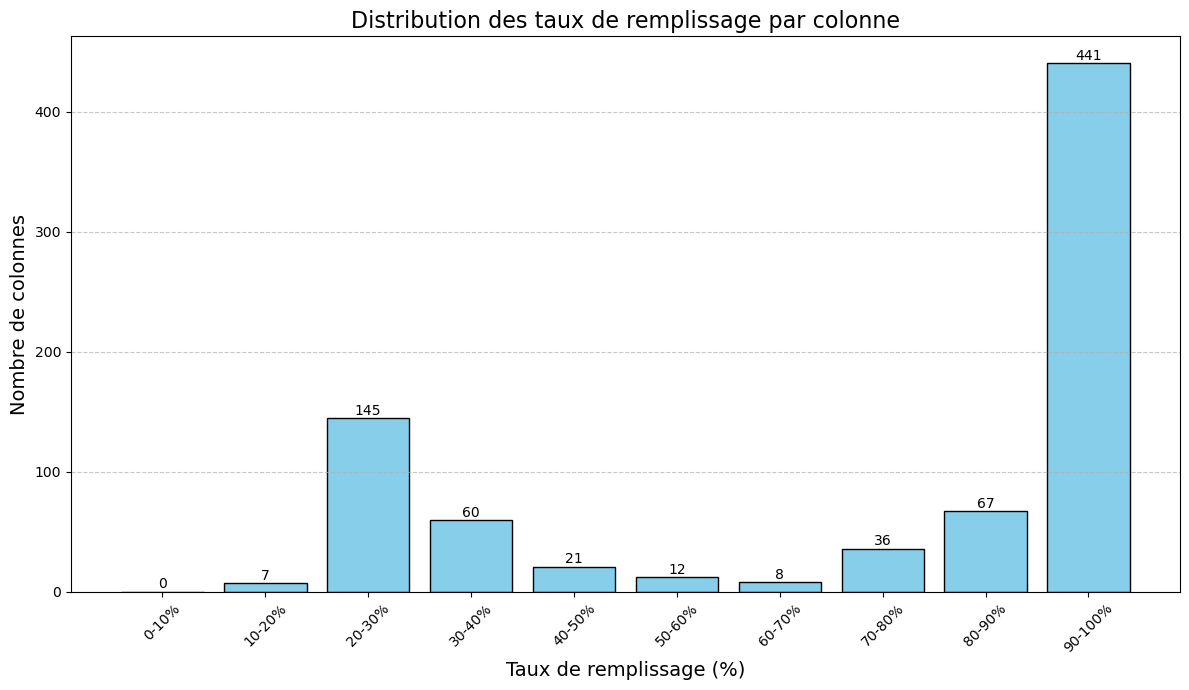

In [11]:
# Calcul du taux de remplissage par colonne
remplissage_par_colonne = df.notnull().mean() * 100

# Calcul du taux de remplissage global
taux_remplissage_global = df.notnull().values.mean() * 100

print("Taux de remplissage par colonne :")
print(remplissage_par_colonne)
print("\nTaux de remplissage global : {:.2f}%".format(taux_remplissage_global))

# Catégorisation des taux de remplissage par tranche de 10%
bins = [i for i in range(0, 101, 10)]
labels = [f'{i}-{i+10}%' for i in bins[:-1]]
remplissage_categorise = pd.cut(remplissage_par_colonne, bins=bins, labels=labels, include_lowest=True)

# Comptage des colonnes par tranche de taux de remplissage
distribution = remplissage_categorise.value_counts().sort_index()

# Création du graphique
plt.figure(figsize=(12, 7))
bars = plt.bar(distribution.index, distribution.values, color='skyblue', edgecolor='black')

# Ajout des étiquettes de valeurs
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom')

# Ajout des titres et des étiquettes des axes
plt.xlabel('Taux de remplissage (%)', fontsize=14)
plt.ylabel('Nombre de colonnes', fontsize=14)
plt.title('Distribution des taux de remplissage par colonne', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.tight_layout()
plt.show()

Fonction de transformation :

In [47]:
# Choix de sélection du modèle avec un paramètres de seuil du taux de remplissage pour la conservation de feature dans le df
def select_features_by_fill_rate(df, threshold=0.8):
    """
    Sélectionne des colonnes d'un DataFrame en fonction d'un seuil de taux de remplissage défini manuellement.
    
    Arguments:
    df -- DataFrame d'entrée.
    threshold -- Seuil pour la sélection des colonnes
    
    Retourne:
    DataFrame avec les colonnes sélectionnées.
    """
    # Calculer le taux de remplissage pour chaque colonne
    fill_rates = df.notna().mean()
    
    # Sélectionner les colonnes dont le taux de remplissage est supérieur au seuil
    selected_columns = fill_rates[fill_rates >= threshold].index
    
    # Retourner le DataFrame avec les colonnes sélectionnées
    return df[selected_columns]

Application & résultat de la fonction :

In [48]:
df = select_features_by_fill_rate(df, threshold=0.8)

Taux de remplissage par colonne :
SK_ID_CURR                        100.000000
TARGET                             86.317512
CODE_GENDER                       100.000000
FLAG_OWN_CAR                      100.000000
FLAG_OWN_REALTY                   100.000000
                                     ...    
INSTAL_AMT_PAYMENT_SUM             95.321276
INSTAL_DAYS_ENTRY_PAYMENT_MAX      95.318750
INSTAL_DAYS_ENTRY_PAYMENT_MEAN     95.318750
INSTAL_DAYS_ENTRY_PAYMENT_SUM      95.321276
INSTAL_COUNT                       95.321276
Length: 508, dtype: float64

Taux de remplissage global : 95.76%


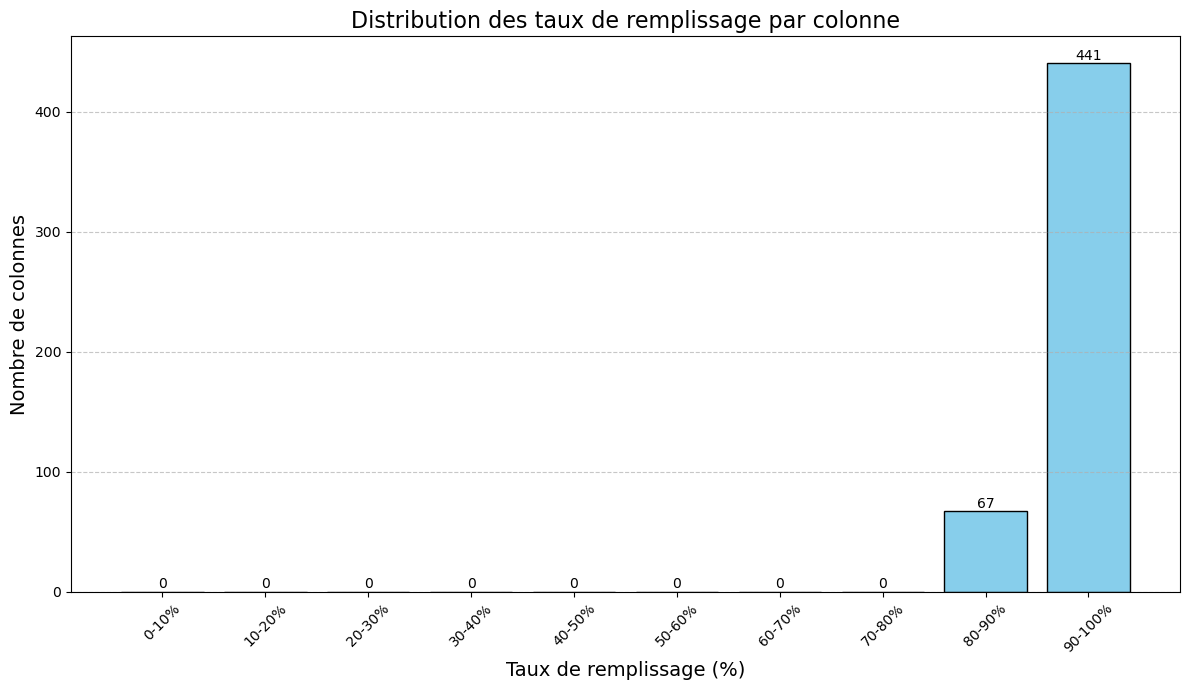

In [49]:
# Calcul du taux de remplissage par colonne
remplissage_par_colonne = df.notnull().mean() * 100

# Calcul du taux de remplissage global
taux_remplissage_global = df.notnull().values.mean() * 100

print("Taux de remplissage par colonne :")
print(remplissage_par_colonne)
print("\nTaux de remplissage global : {:.2f}%".format(taux_remplissage_global))

# Catégorisation des taux de remplissage par tranche de 10%
bins = [i for i in range(0, 101, 10)]
labels = [f'{i}-{i+10}%' for i in bins[:-1]]
remplissage_categorise = pd.cut(remplissage_par_colonne, bins=bins, labels=labels, include_lowest=True)

# Comptage des colonnes par tranche de taux de remplissage
distribution = remplissage_categorise.value_counts().sort_index()

# Création du graphique
plt.figure(figsize=(12, 7))
bars = plt.bar(distribution.index, distribution.values, color='skyblue', edgecolor='black')

# Ajout des étiquettes de valeurs
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom')

# Ajout des titres et des étiquettes des axes
plt.xlabel('Taux de remplissage (%)', fontsize=14)
plt.ylabel('Nombre de colonnes', fontsize=14)
plt.title('Distribution des taux de remplissage par colonne', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.tight_layout()
plt.show()


In [51]:
df.to_csv('df_without_nan.csv', index = True)

## B. Features selection SVM avec pénalité L1

In [52]:
df = pd.read_csv('df_without_nan.csv')

In [53]:
df.shape

(356251, 509)

In [54]:
valeurnantarget = df['TARGET'].isnull().sum()
print(valeurnantarget)

48744


In [55]:
# Création d'un échantillon des données / groupement par la colonne 'TARGET' et échantillonnage de 20000 lignes pour chaque groupe
df_light = df.groupby('TARGET', as_index=False).apply(
    lambda s: s.sample(20000, random_state=0))

# Réinitialisation des index
df_light.reset_index(inplace=True)

# Définir 'SK_ID_CURR' comme index
df_light.set_index('SK_ID_CURR', inplace=True)

# Suppression de la colonne inutile 'level_0'
df_light.drop(columns='level_0', inplace=True)
df_light.drop(columns='level_1', inplace=True)

# Remplissage des valeurs NaN par 0
df_light.fillna(0, inplace=True)

# Remplacer les valeurs infinies par 0
df_light.replace([np.inf, -np.inf], 0, inplace=True)

In [56]:
df_light.TARGET.value_counts()

TARGET
0.0    20000
1.0    20000
Name: count, dtype: int64

In [57]:
# Séparation matrice X & target y
X = df_light.drop(columns='TARGET')
y = df_light['TARGET']

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer le SVM linéaire avec pénalité L1
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(X_scaled, y)

# Sélectionner les caractéristiques importantes
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

# Afficher les caractéristiques sélectionnées
selected_features = X.columns[model.get_support()]

print("Caractéristiques sélectionnées :")
print(selected_features)
print(selected_features.shape)

Caractéristiques sélectionnées :
Index(['Unnamed: 0', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_PAYMENT_DIFF_SUM', 'INSTAL_PAYMENT_DIFF_VAR',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=327)
(327,)


In [58]:
len(list(X.columns[model.get_support()]))

327

In [59]:
df_light_selec = df[list(X.columns[model.get_support()])].copy()
df_light_selec['TARGET'] = df['TARGET']

In [60]:
list(df_light_selec.columns)

['Unnamed: 0',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CR

In [65]:
df_light_selec.drop(columns='Unnamed: 0', inplace=True)

In [66]:
df_light_selec.to_csv('df_after_FS.csv', index=False)

## C. Sélection selon l'importance des features avec le LightGBM

### 1. Analyse et expérimentation

In [66]:
df = pd.read_csv('df_after_FS.csv')

Fontion de préparation & d'initialisation du modèle LightGBM

In [67]:
def prepare_and_train_model(df, target_column='TARGET'):
    """
    Prépare les données et entraîne un modèle LightGBM.

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    target_column (str): Le nom de la colonne cible.

    Returns:
    lgb.LGBMClassifier: Le classificateur entraîné.
    """
    # Suppression des lignes contenant des NaN dans la cible
    df = df.dropna(subset=[target_column])

    # Nettoyage des noms de colonnes
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

    # Préparation des données pour la modélisation
    X = df.drop(columns=target_column).fillna(0)
    y = df[target_column]

    # Vérification des valeurs manquantes
    if X.isnull().sum().sum() > 0:
        raise ValueError("Il y a encore des valeurs NaN dans les données d'entrée.")

    if y.isnull().sum() > 0:
        raise ValueError("Il y a des valeurs NaN dans la cible.")

    # Création du classifier lightgbm
    clf = lgb.LGBMClassifier(objective="binary", n_jobs=-1, is_unbalance=True)

    # Entraînement du modèle
    clf.fit(X, y)

    return clf, X

Exécution du script créé ci-dessus :

In [68]:
model, X = prepare_and_train_model(df)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.477680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27833
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432471
[LightGBM] [Info] Start training from score -2.432471


Analyse du résultat du modèle initialisé : 

In [69]:
def analyze_feature_importance(model, X):
    """
    Analyse l'importance des features du modèle entraîné.

    Parameters:
    model (lgb.LGBMClassifier): Le classificateur LightGBM entraîné.
    X (pd.DataFrame): Les données d'entrée utilisées pour entraîner le modèle.

    Returns:
    pd.DataFrame: Un DataFrame contenant les importances des features.
    """
    # Récupération de l'importance des features
    feature_importances = model.feature_importances_
    features = X.columns

    # Création d'un DataFrame pour les importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    return importance_df

In [70]:
importance_df = analyze_feature_importance(model, X)

In [71]:
total_exp = importance_df['Importance'].sum()
print('Total des valaurs d\'importance', total_exp)
importance_df['pourcentage_exp'] = (importance_df['Importance']/ total_exp)*100

Total des valaurs d'importance 3000


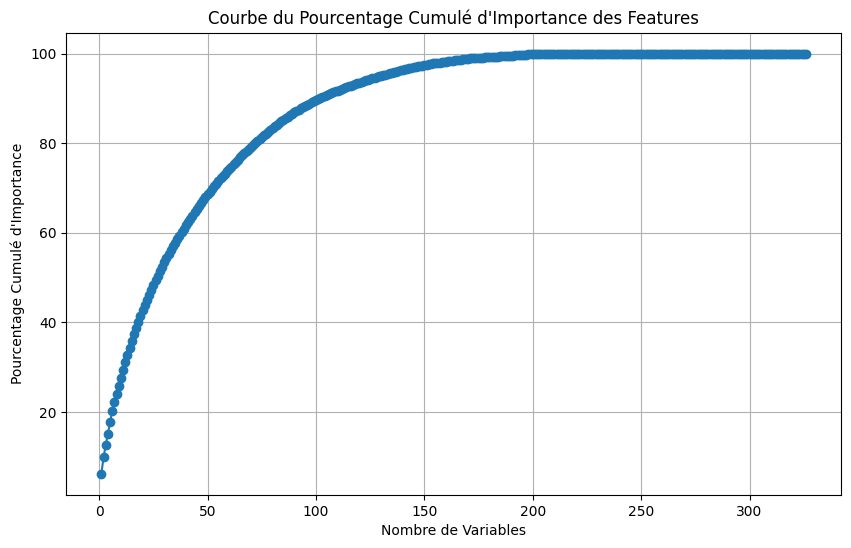

In [72]:
# Calculer le pourcentage cumulé
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['pourcentage_exp'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df['cumulative_percentage'] = importance_df['pourcentage_exp'].cumsum()

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1), importance_df['cumulative_percentage'], marker='o', linestyle='-')
plt.xlabel('Nombre de Variables')
plt.ylabel('Pourcentage Cumulé d\'Importance')
plt.title('Courbe du Pourcentage Cumulé d\'Importance des Features')
plt.grid(True)
plt.show()

In [73]:
def select_top_features(importance_df, threshold=95):
    """
    Sélectionne les variables qui permettent de conserver un certain pourcentage d'explicabilité du modèle.

    Parameters:
    importance_df (pd.DataFrame): DataFrame contenant les features et leur importance.
    threshold (float): Pourcentage d'explicabilité à conserver (default: 95).

    Returns:
    pd.DataFrame: DataFrame des features conservées.
    """
    # Trier les features par importance décroissante
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Calculer le pourcentage d'explicabilité
    importance_df['pourcentage_exp'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
    importance_df['cumulative_percentage'] = importance_df['pourcentage_exp'].cumsum()
    
    # Sélectionner les features qui permettent de conserver le pourcentage d'explicabilité désiré
    selected_features = importance_df[importance_df['cumulative_percentage'] <= threshold]
    num_selected_features = len(selected_features)
    
    # Afficher le nombre de features conservées
    print(f"Nombre de variables conservées: {num_selected_features}")
    
    return selected_features

In [74]:
# Appel de la fonction
selected_features = select_top_features(importance_df)
selected_features

Nombre de variables conservées: 129


Feature  Importance  pourcentage_exp  \
155                                 PAYMENT_RATE         186         6.200000   
22                                  EXT_SOURCE_2         109         3.633333   
23                                  EXT_SOURCE_3          83         2.766667   
193                        PREV_CNT_PAYMENT_MEAN          77         2.566667   
6                                    AMT_ANNUITY          76         2.533333   
..                                           ...         ...              ...   
185                         PREV_AMT_ANNUITY_MAX           5         0.166667   
259                 PREV_CHANNEL_TYPE_Stone_MEAN           5         0.166667   
153                            INCOME_PER_PERSON           4         0.133333   
196  PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN           4         0.133333   
223              PREV_CODE_REJECT_REASON_HC_MEAN           4         0.133333   

     cumulative_percentage  
155               6.200000  
22                9.833333  
23               12.600000  
193              15.166667  
6                17.700000  
..                     ...  
185              94.366667  
259              94.533333  
153              94.666667  
196              94.800000  
223              94.933333  

[129 rows x 4 columns]

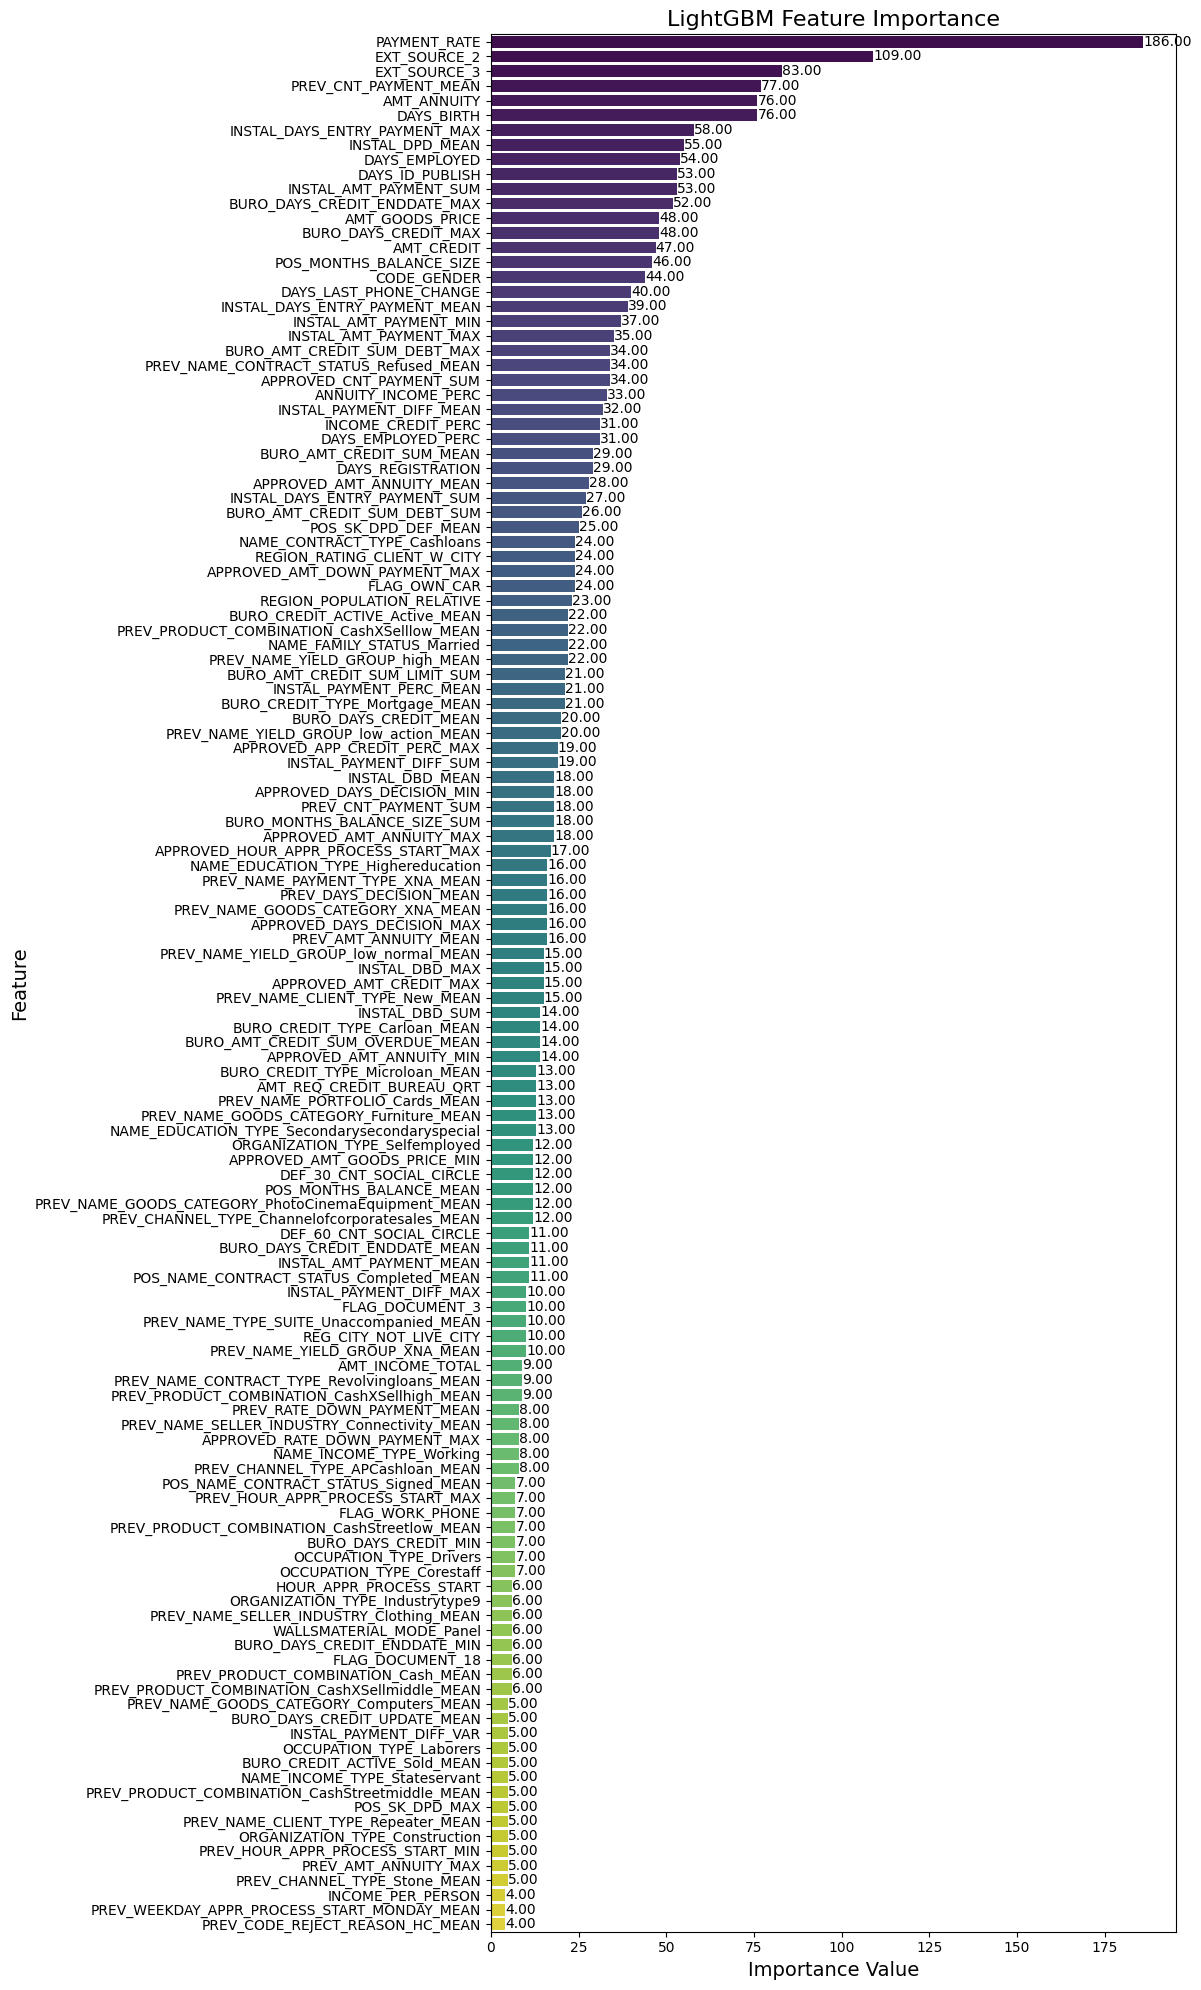

In [75]:
def visualize_selected_features(selected_features):
    """
    Visualise les features conservées avec un graphique en barres.

    Parameters:
    selected_features (pd.DataFrame): DataFrame des features conservées.
    """
    # Représentation graphique
    plt.figure(figsize=(12, 20))
    ax = sns.barplot(x="Importance", y="Feature", data=selected_features, palette='viridis')
    
    # Ajouter les étiquettes de valeurs à la fin de chaque barre
    for index, value in enumerate(selected_features['Importance']):
        plt.text(value, index, f'{value:.2f}', color='black', va="center")
    
    plt.title('LightGBM Feature Importance', fontsize=16)
    plt.xlabel('Importance Value', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_selected_features(selected_features)

In [91]:
selected_features

Feature  Importance  pourcentage_exp  \
155                                 PAYMENT_RATE         186         6.200000   
22                                  EXT_SOURCE_2         109         3.633333   
23                                  EXT_SOURCE_3          83         2.766667   
193                        PREV_CNT_PAYMENT_MEAN          77         2.566667   
6                                    AMT_ANNUITY          76         2.533333   
..                                           ...         ...              ...   
185                         PREV_AMT_ANNUITY_MAX           5         0.166667   
259                 PREV_CHANNEL_TYPE_Stone_MEAN           5         0.166667   
153                            INCOME_PER_PERSON           4         0.133333   
196  PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN           4         0.133333   
223              PREV_CODE_REJECT_REASON_HC_MEAN           4         0.133333   

     cumulative_percentage  
155               6.200000  
22                9.833333  
23               12.600000  
193              15.166667  
6                17.700000  
..                     ...  
185              94.366667  
259              94.533333  
153              94.666667  
196              94.800000  
223              94.933333  

[129 rows x 4 columns]

### 2. Script de la fonction

In [22]:
def prepare_train_analyze_select(df, target_column='TARGET', threshold=95):
    """
    Prépare les données, entraîne un modèle LightGBM, analyse l'importance des features,
    sélectionne les features les plus importantes jusqu'à atteindre 95% d'explicabilité,
    et renvoie le DataFrame initial filtré avec ces features.

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    target_column (str): Le nom de la colonne cible.
    threshold (float): Pourcentage d'explicabilité à conserver (default: 95).

    Returns:
    pd.DataFrame: DataFrame initial filtré avec les features sélectionnées.
    """
    # Suppression des lignes contenant des NaN dans la cible
    df = df.dropna(subset=[target_column])

    # Nettoyage des noms de colonnes
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

    # Préparation des données pour la modélisation
    X = df.drop(columns=target_column).fillna(0)
    y = df[target_column]

    # Vérification des valeurs manquantes
    if X.isnull().sum().sum() > 0:
        raise ValueError("Il y a encore des valeurs NaN dans les données d'entrée.")

    if y.isnull().sum() > 0:
        raise ValueError("Il y a des valeurs NaN dans la cible.")

    # Création du classifier lightgbm
    clf = lgb.LGBMClassifier(objective="binary", n_jobs=-1, is_unbalance=True)

    # Entraînement du modèle
    clf.fit(X, y)

    # Analyse de l'importance des features
    feature_importances = clf.feature_importances_
    features = X.columns

    # Création d'un DataFrame pour les importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Calculer le pourcentage d'explicabilité
    importance_df['pourcentage_exp'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
    importance_df['cumulative_percentage'] = importance_df['pourcentage_exp'].cumsum()

    # Sélectionner les features qui permettent de conserver le pourcentage d'explicabilité désiré
    selected_features = importance_df[importance_df['cumulative_percentage'] <= threshold]
    num_selected_features = len(selected_features)
    
    # Afficher le nombre de features conservées
    print(f"Nombre de variables conservées: {num_selected_features}")

    # Filtrer le DataFrame initial avec les features sélectionnées
    selected_columns = selected_features['Feature'].tolist()
    filtered_df = df[selected_columns + [target_column]].copy()

    # Supprimer la colonne 'Unnamed: 0' si elle existe
    if 'Unnamed: 0' in filtered_df.columns:
        filtered_df = filtered_df.drop(columns=['Unnamed: 0'])

    # Remplacer les valeurs infinies par NaN, puis remplacer les NaN par 0
    filtered_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    filtered_df.fillna(0, inplace=True)

    # Enregistrer le DataFrame filtré en CSV
    filtered_df.to_csv('df_mod.csv', index=True)

    return filtered_df, clf, selected_features


In [23]:
# Utilisation de la fonction
df = pd.read_csv('df_after_FS.csv')
filtered_df, model, selected_features = prepare_train_analyze_select(df, target_column='TARGET', threshold=95)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.328108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27833
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432471
[LightGBM] [Info] Start training from score -2.432471
Nombre de variables conservées: 129


<Axes: >

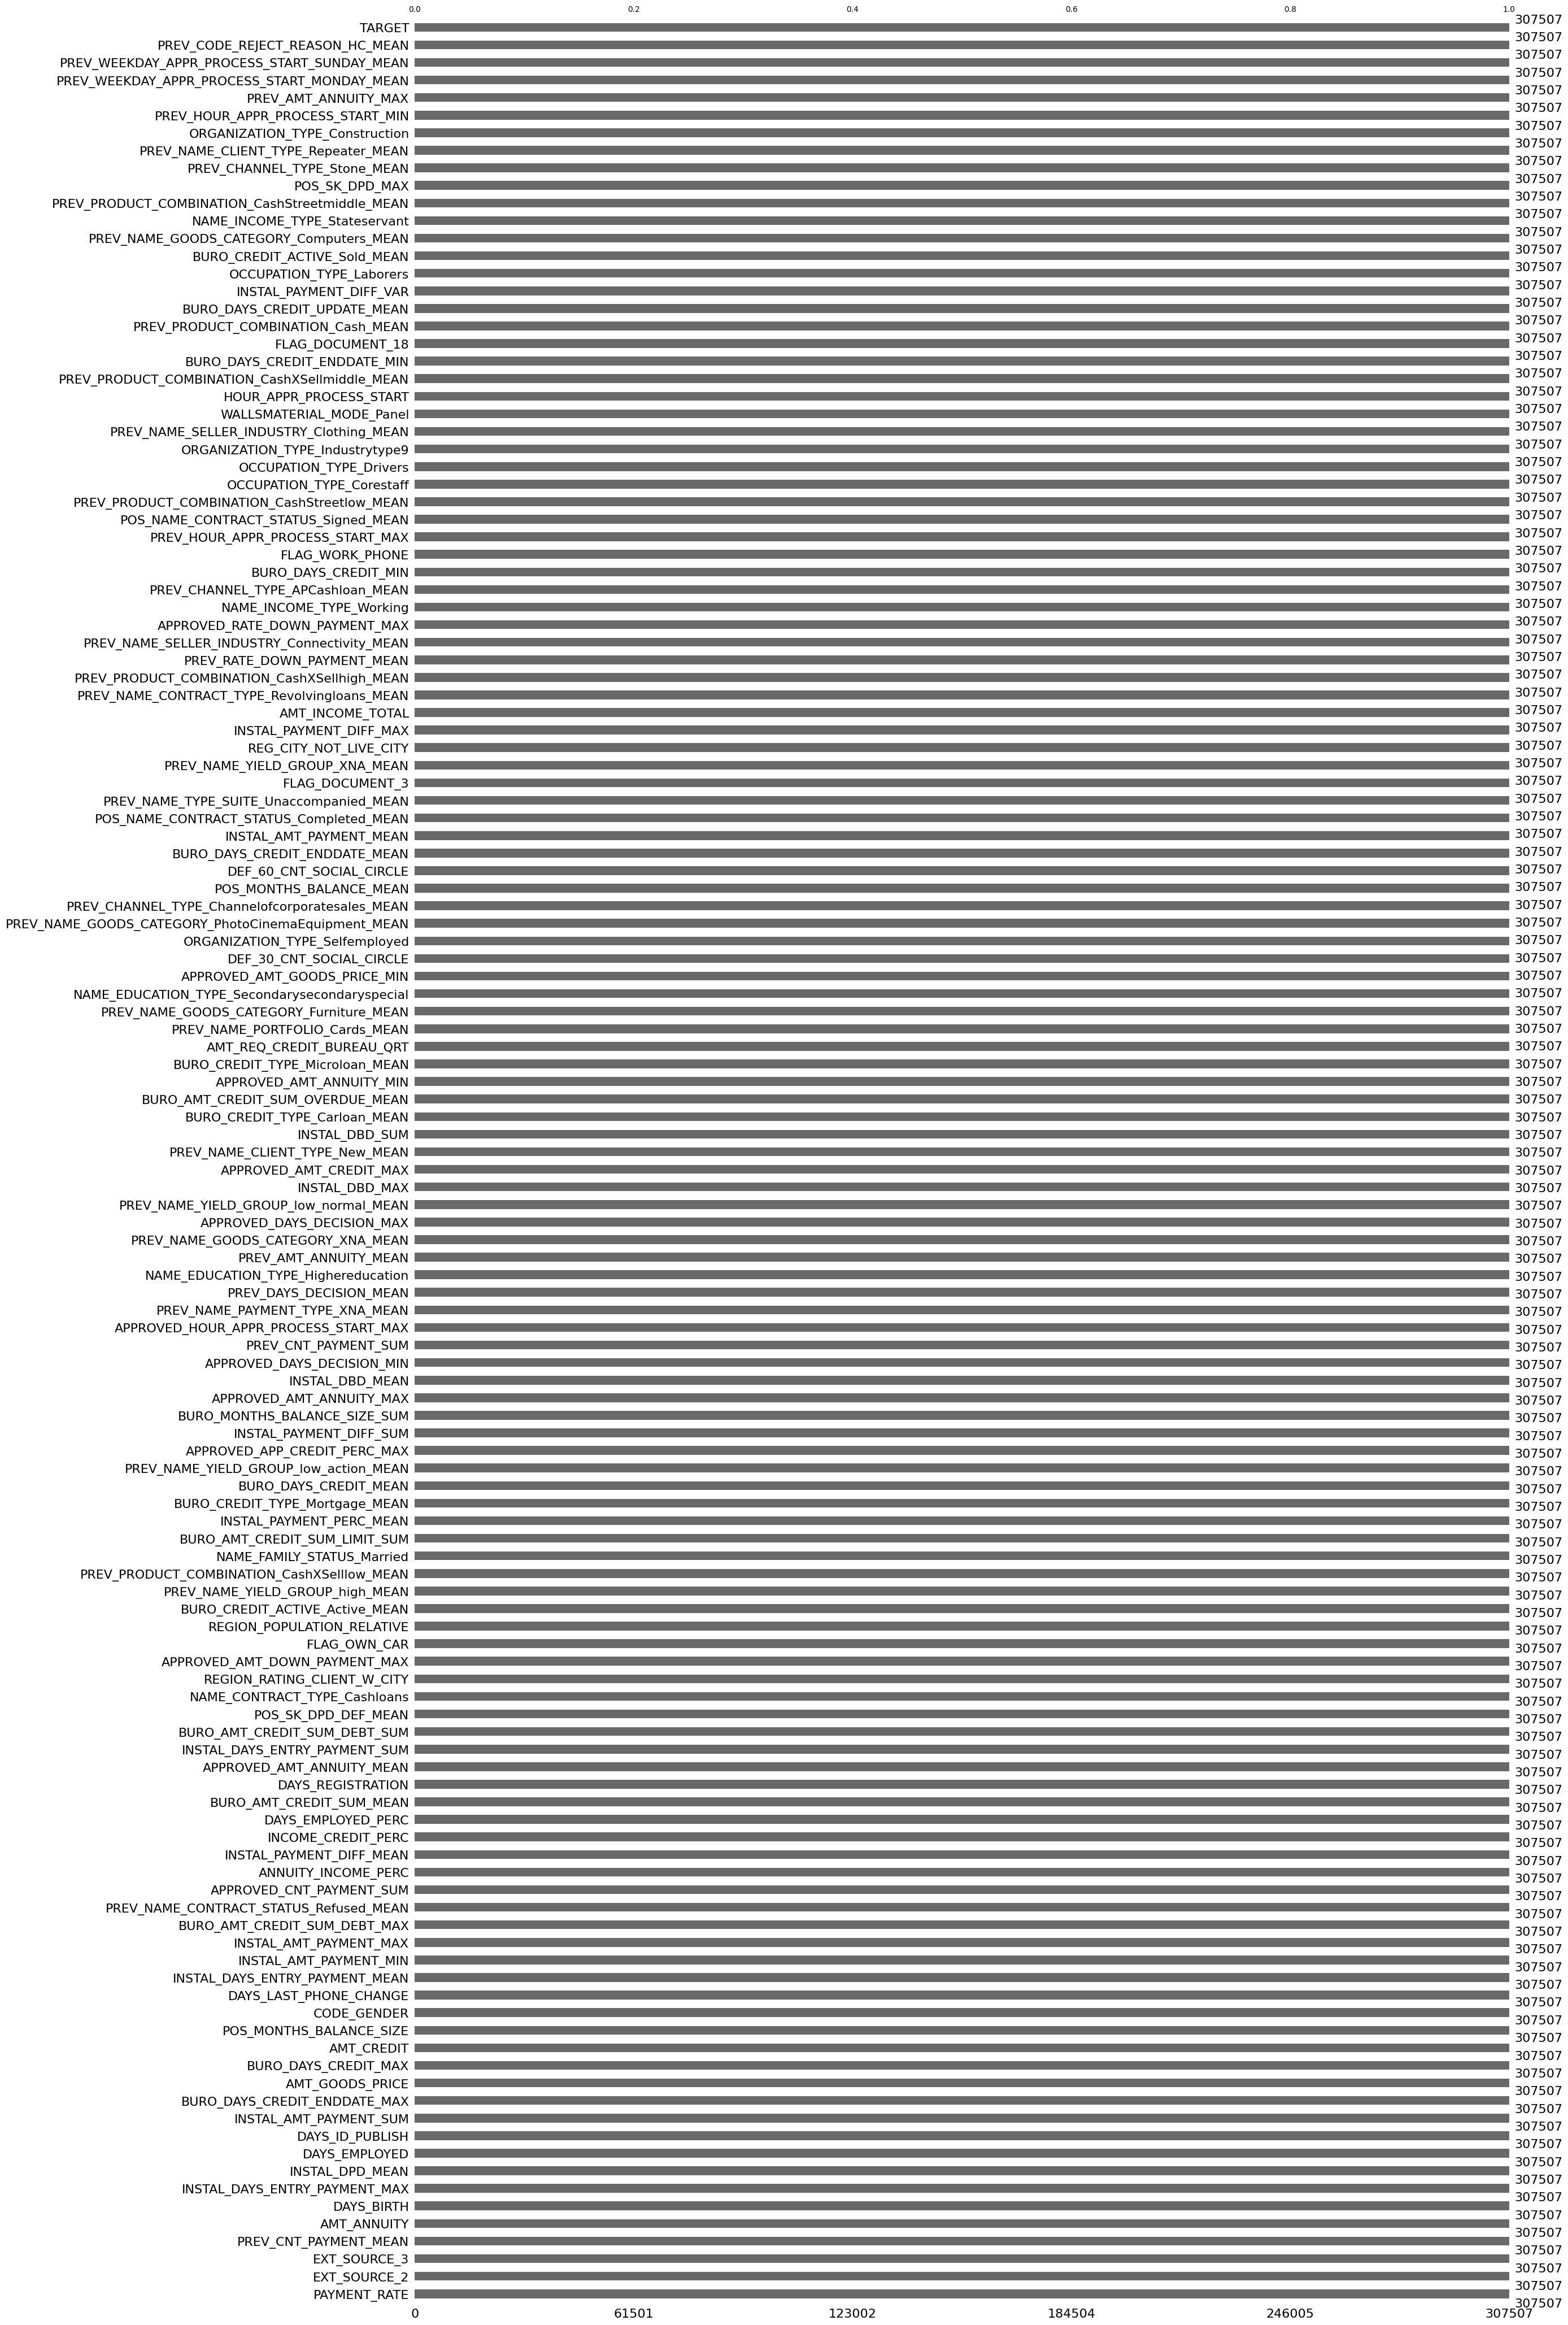

In [24]:
msno.bar(filtered_df)